# Imports

In [3]:
# imports
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import jams

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks')

import IPython.display as ipd
from IPython.display import Audio

C:\Users\derob\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Extract labels
- Define paths for audio, annotations, images, labels
- Get list of song file names and list of annotations file names (they are all in order)
- For each annotation file:
-- Create `chords_song_instructed` and `chords_song_played` dataframe with name row names as `song name_1`, `song_name_2`... containing info on chords instructed and chords played
-- Append dataframe to `chords_instructed` and `chords_played` dataframe
- merge the dataframes as `chords_all`
- keep only 'comp' (discard solos)
- keep only rows where `chord_played` contains one of the root chords (my labels will be chords_instructed)
- For each audio file
-- load audio slices I'll be using(based on starts in `chords_all`) in librosa
-- create chromagram and save under the same name than the id from the dataframe

#### Define paths & get lists of file names

In [2]:
# Define paths for audio, annotations, images, labels
path_audio = "audio_hex-pickup_debleeded/"
path_annotations = "annotation/"
path_images = "images/"
path_labels = "labels/"

audio_files = sorted(os.listdir(path_audio))
annotation_files = sorted(os.listdir(path_annotations))
track_names = [name[:-5] for name in annotation_files]

NameError: name 'os' is not defined

In [6]:
# make sure the files correspond to each other between audio and annotations
files = pd.DataFrame({"track name": track_names, "audio_file": audio_files, "annotation_file": annotation_files})
files.tail(5)

,track name,audio_file,annotation_file
355,05_SS2-88-F_solo,05_SS2-88-F_solo_hex_cln.wav,05_SS2-88-F_solo.jams
356,05_SS3-84-Bb_comp,05_SS3-84-Bb_comp_hex_cln.wav,05_SS3-84-Bb_comp.jams
357,05_SS3-84-Bb_solo,05_SS3-84-Bb_solo_hex_cln.wav,05_SS3-84-Bb_solo.jams
358,05_SS3-98-C_comp,05_SS3-98-C_comp_hex_cln.wav,05_SS3-98-C_comp.jams
359,05_SS3-98-C_solo,05_SS3-98-C_solo_hex_cln.wav,05_SS3-98-C_solo.jams


#### Loop through annotation files

In [11]:
# extract chords from annotations_files
chords_instructed = pd.DataFrame()
chords_played = pd.DataFrame()

for file in annotation_files:
    # load the file
    jam = jams.load(path_annotations + file)

    # create chords_song dataframe
    start_list_instructed = []
    start_list_played = []
    chord_list_instructed = []
    chord_list_played = []
    duration_list_instructed = []
    duration_list_played = []
    id_list_played = []
    id_list_instructed = []

    for i in range(0, len(jam['annotations'])):   
        if jam['annotations'][int(i)]['namespace'] == 'chord':
            if jam['annotations'][int(i)]['annotation_metadata']['annotation_rules'] == '':
                for j in range(0, len(sorted(jam['annotations'][int(i)]['data']))):
                    line = list(jam['annotations'][int(i)]['data'][int(j)])[:-1]
                    start_list_instructed.append(line[0])
                    duration_list_instructed.append(line[1])
                    chord_list_instructed.append(line[2])
                    id_list_instructed.append(file[:-5] + '_' + str(j))
            else:
                for j in range(0, len(sorted(jam['annotations'][int(i)]['data']))):
                    line = list(jam['annotations'][int(i)]['data'][int(j)])[:-1]
                    start_list_played.append(line[0])
                    duration_list_played.append(line[1])
                    chord_list_played.append(line[2])
                    id_list_played.append(file[:-5] + '_' + str(j))

        chords_song_instructed = pd.DataFrame({'id_instructed': id_list_instructed, 'time_instructed':start_list_instructed, 'duration_instructed':duration_list_instructed, 'chord_instructed':chord_list_instructed})
        chords_song_played = pd.DataFrame({'id_played': id_list_played, 'time_played':start_list_played, 'duration_played':duration_list_played, 'chord_played':chord_list_played})
        chords_song_instructed['track_name'] = file[:-5]
        chords_song_played['track_name'] = file[:-5]

    chords_instructed = pd.concat([chords_instructed, chords_song_instructed])
    chords_played = pd.concat([chords_played, chords_song_played])

In [15]:
print(chords_instructed.shape)
print(chords_played.shape)

(4320, 5)
(4320, 5)


#### merge dataframes and keep only rows we'll be using
- merge the dataframes as chords_all
- keep only 'comp' (discard solos)
- keep only rows where chord_played contains one of the root chords
- add a new column with root chord info

In [12]:
# merge dataframes
chords_instructed = chords_instructed.rename(columns={"id_instructed":"id"})
chords_played = chords_played.rename(columns={"id_played":"id"})

chords_all = chords_instructed.merge(chords_played, on='id')

In [13]:
# format the dataframe
chords_all = chords_all.drop(['time_played', 'duration_played', 'track_name_y'], axis=1)
chords_all = chords_all.rename(columns = {'time_instructed': 'time', 'duration_instructed': 'duration', 'track_name_x': 'track_name'})
chords_all = chords_all[['id', 'track_name', 'time', 'duration', 'chord_instructed', 'chord_played']]

In [14]:
# export dataframe
chords_all.to_csv("labels/chords_all.csv")

In [16]:
# get comp only
chords_comp = chords_all[chords_all['track_name'].str.contains("comp")]

In [17]:
# keep only rows where chord_played contains chord instructed (discrad rows where player did something else)
chord_list = sorted(chords_comp.chord_instructed.unique())

In [152]:
chord_list

['A#:7',
 'A#:hdim7',
 'A#:maj',
 'A#:min',
 'A:7',
 'A:hdim7',
 'A:maj',
 'A:min',
 'B:maj',
 'B:min',
 'C#:7',
 'C#:hdim7',
 'C#:maj',
 'C#:min',
 'C:7',
 'C:hdim7',
 'C:maj',
 'C:min',
 'D#:7',
 'D#:maj',
 'D#:min',
 'D:7',
 'D:maj',
 'D:min',
 'E:7',
 'E:hdim7',
 'E:maj',
 'E:min',
 'F#:7',
 'F#:maj',
 'F#:min',
 'F:7',
 'F:hdim7',
 'F:maj',
 'F:min',
 'G#:7',
 'G#:hdim7',
 'G#:maj',
 'G#:min',
 'G:hdim7',
 'G:maj',
 'G:min']

In [30]:
chords_comp.head()

,to_keep,id,track_name,time,duration,chord_instructed,chord_played
0,False,00_BN1-129-Eb_comp_0,00_BN1-129-Eb_comp,0.000000,7.441860,D#:maj,D#:sus2(7)/1
1,True,00_BN1-129-Eb_comp_1,00_BN1-129-Eb_comp,7.441860,3.720930,G#:maj,G#:maj6(*5)/1
2,True,00_BN1-129-Eb_comp_2,00_BN1-129-Eb_comp,11.162791,3.720930,D#:maj,D#:maj7/1
3,True,00_BN1-129-Eb_comp_3,00_BN1-129-Eb_comp,14.883721,1.860465,A#:maj,A#:maj/1
4,True,00_BN1-129-Eb_comp_4,00_BN1-129-Eb_comp,16.744186,1.860465,G#:maj,"G#:maj6(2,b5,*5)/1"


In [61]:
chords_comp.insert(loc = 0, column = "to_keep", value = False, allow_duplicates = True)

In [59]:
chords_comp = chords_comp.drop('to_keep', axis=1)

In [62]:
chords_comp.head()

,to_keep,id,track_name,time,duration,chord_instructed,chord_played
0,False,00_BN1-129-Eb_comp_0,00_BN1-129-Eb_comp,0.000000,7.441860,D#:maj,D#:sus2(7)/1
1,False,00_BN1-129-Eb_comp_1,00_BN1-129-Eb_comp,7.441860,3.720930,G#:maj,G#:maj6(*5)/1
2,False,00_BN1-129-Eb_comp_2,00_BN1-129-Eb_comp,11.162791,3.720930,D#:maj,D#:maj7/1
3,False,00_BN1-129-Eb_comp_3,00_BN1-129-Eb_comp,14.883721,1.860465,A#:maj,A#:maj/1
4,False,00_BN1-129-Eb_comp_4,00_BN1-129-Eb_comp,16.744186,1.860465,G#:maj,"G#:maj6(2,b5,*5)/1"


In [66]:
for index, row in chords_comp.iterrows():
    if str(row['chord_instructed']) in str(row['chord_played']):
        chords_comp.loc[index, "to_keep"] = True

In [68]:
chords_comp.head()

,to_keep,id,track_name,time,duration,chord_instructed,chord_played
0,False,00_BN1-129-Eb_comp_0,00_BN1-129-Eb_comp,0.000000,7.441860,D#:maj,D#:sus2(7)/1
1,True,00_BN1-129-Eb_comp_1,00_BN1-129-Eb_comp,7.441860,3.720930,G#:maj,G#:maj6(*5)/1
2,True,00_BN1-129-Eb_comp_2,00_BN1-129-Eb_comp,11.162791,3.720930,D#:maj,D#:maj7/1
3,True,00_BN1-129-Eb_comp_3,00_BN1-129-Eb_comp,14.883721,1.860465,A#:maj,A#:maj/1
4,True,00_BN1-129-Eb_comp_4,00_BN1-129-Eb_comp,16.744186,1.860465,G#:maj,"G#:maj6(2,b5,*5)/1"


In [81]:
chords_comp_clean = chords_comp[chords_comp.to_keep == True]

In [69]:
# make sure it worked
print(chords_comp.shape)
chords_comp_clean.shape

(144, 7)


(111, 7)

In [135]:
# unique chords instructed
chords_comp_clean.chord_instructed.value_counts()

F:maj       122
C:maj        98
G:maj        94
D#:maj       90
C#:maj       79
G#:maj       75
A#:maj       74
F#:maj       73
E:maj        70
D:maj        69
A:maj        67
B:maj        62
E:min        51
G:min        47
C#:min       42
A#:min       38
G#:min       37
A:min        33
B:min        33
D:min        30
F:min        28
D#:7         25
C:min        20
F#:min       19
F#:7         18
D#:min       18
C:7          17
A:7          16
G:hdim7      14
A#:hdim7     14
F:7          12
C#:7         11
G#:hdim7      8
F:hdim7       8
A#:7          8
C:hdim7       7
G#:7          6
E:hdim7       6
E:7           6
C#:hdim7      6
D:7           4
A:hdim7       4
Name: chord_instructed, dtype: int64

In [141]:
chords_comp_clean = chords_comp_clean.reset_index().drop('index', axis=1)

In [133]:
chords_comp_clean=chords_comp_clean.dropna()

In [140]:
# export dataframe
chords_comp_clean.to_csv("labels/chords_comp_clean.csv")

In [154]:
# export dataframe
chords_comp.to_csv("labels/chords_comp.csv")

#### Loop through audio files

In [119]:
audio_files[:2]

['00_BN1-129-Eb_comp_hex_cln.wav', '00_BN1-129-Eb_solo_hex_cln.wav']

<ipython-input-131-3238b9923b76>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(2, 2))
/opt/conda/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=997
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=499
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=996
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=695
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/libr

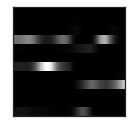

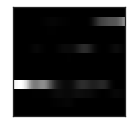

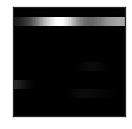

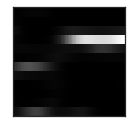

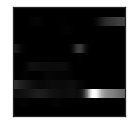

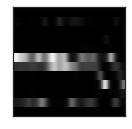

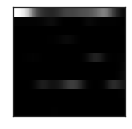

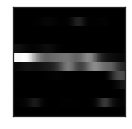

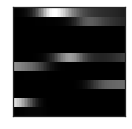

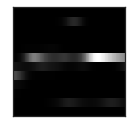

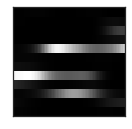

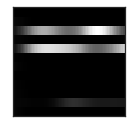

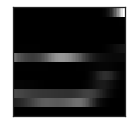

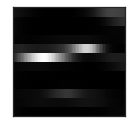

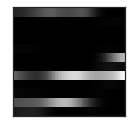

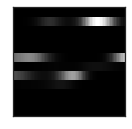

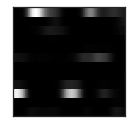

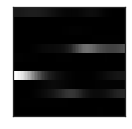

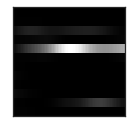

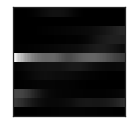

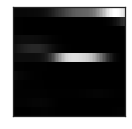

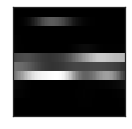

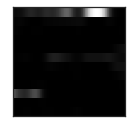

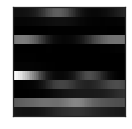

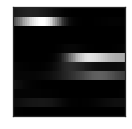

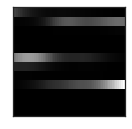

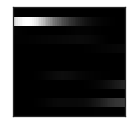

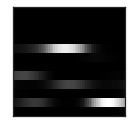

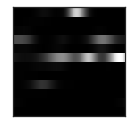

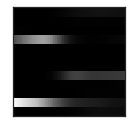

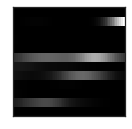

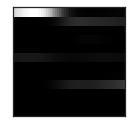

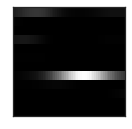

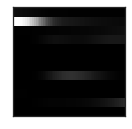

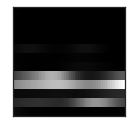

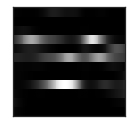

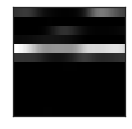

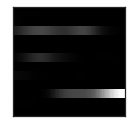

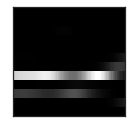

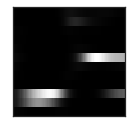

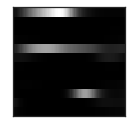

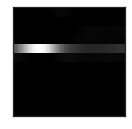

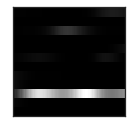

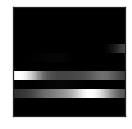

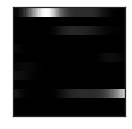

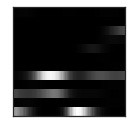

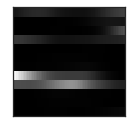

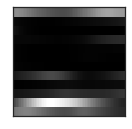

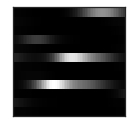

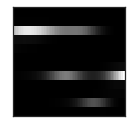

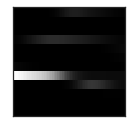

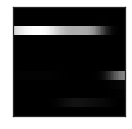

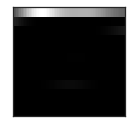

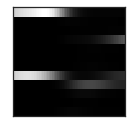

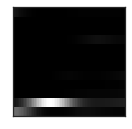

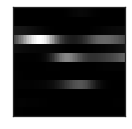

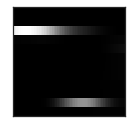

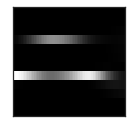

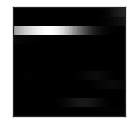

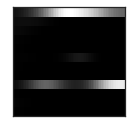

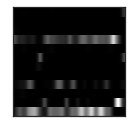

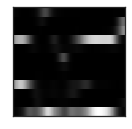

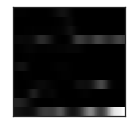

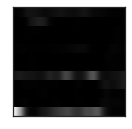

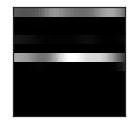

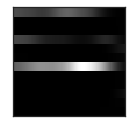

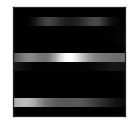

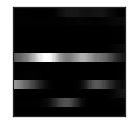

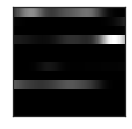

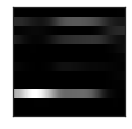

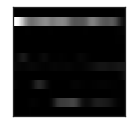

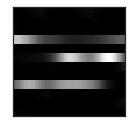

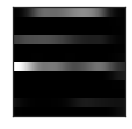

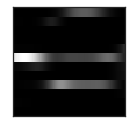

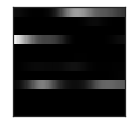

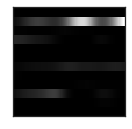

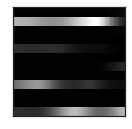

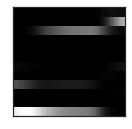

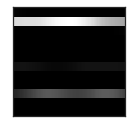

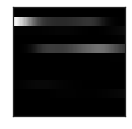

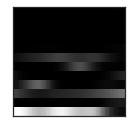

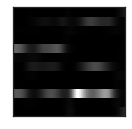

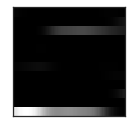

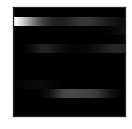

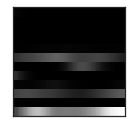

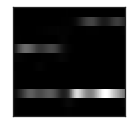

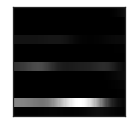

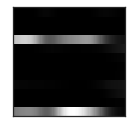

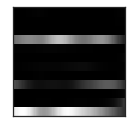

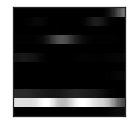

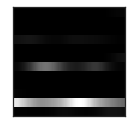

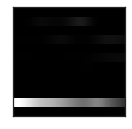

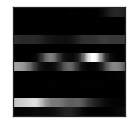

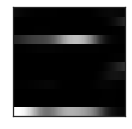

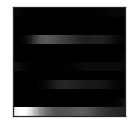

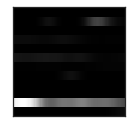

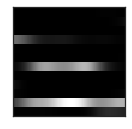

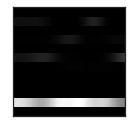

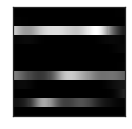

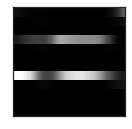

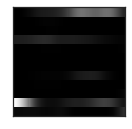

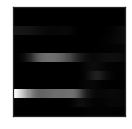

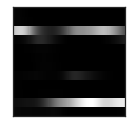

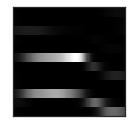

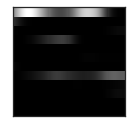

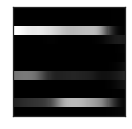

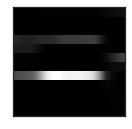

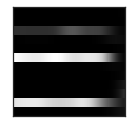

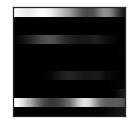

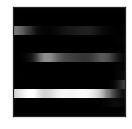

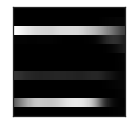

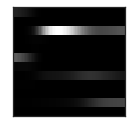

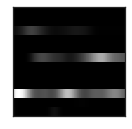

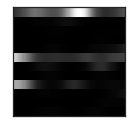

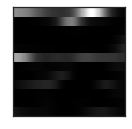

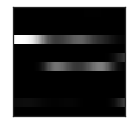

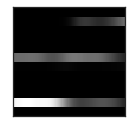

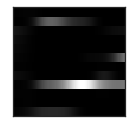

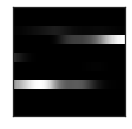

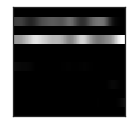

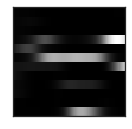

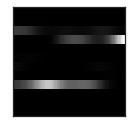

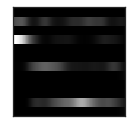

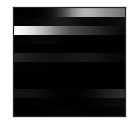

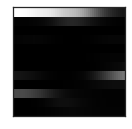

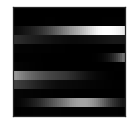

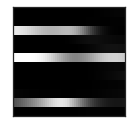

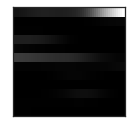

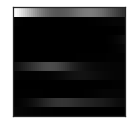

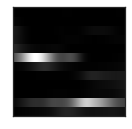

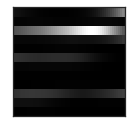

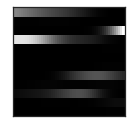

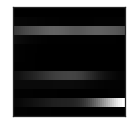

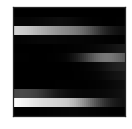

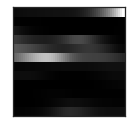

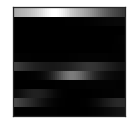

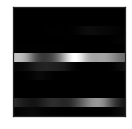

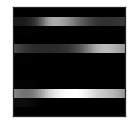

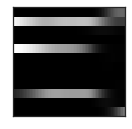

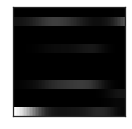

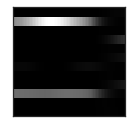

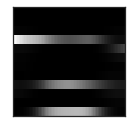

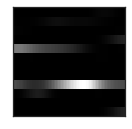

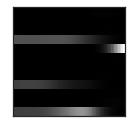

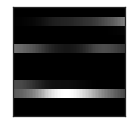

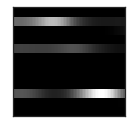

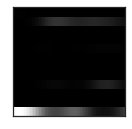

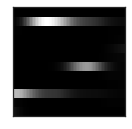

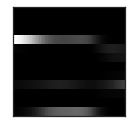

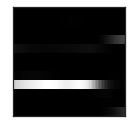

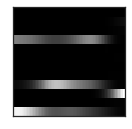

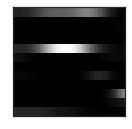

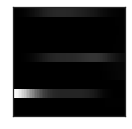

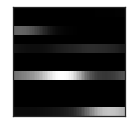

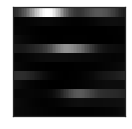

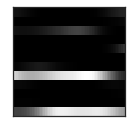

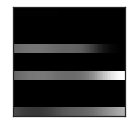

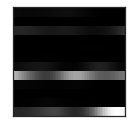

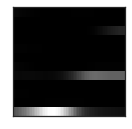

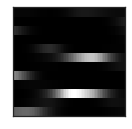

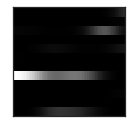

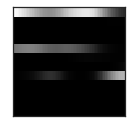

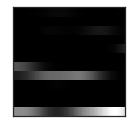

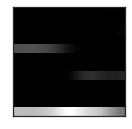

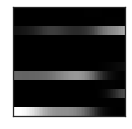

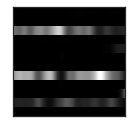

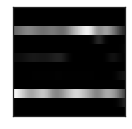

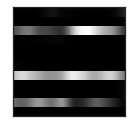

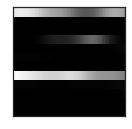

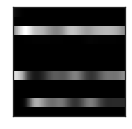

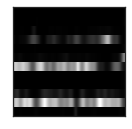

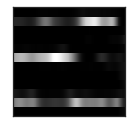

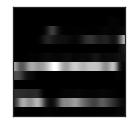

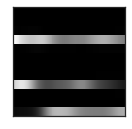

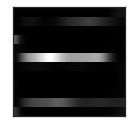

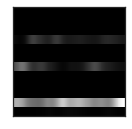

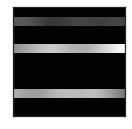

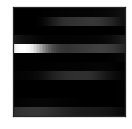

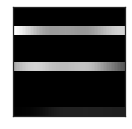

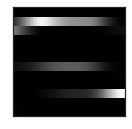

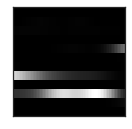

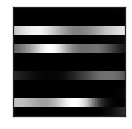

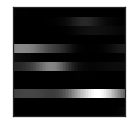

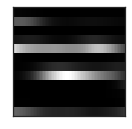

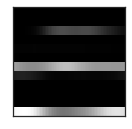

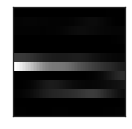

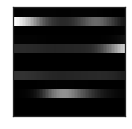

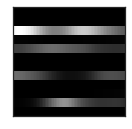

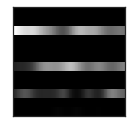

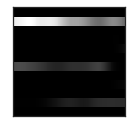

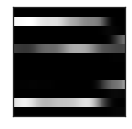

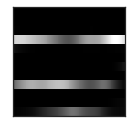

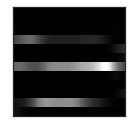

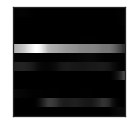

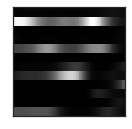

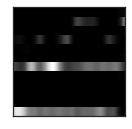

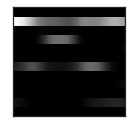

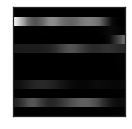

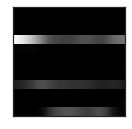

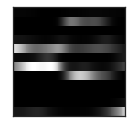

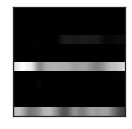

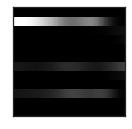

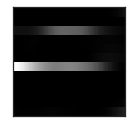

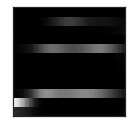

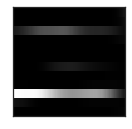

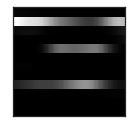

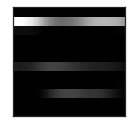

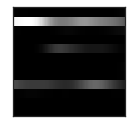

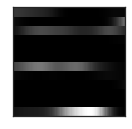

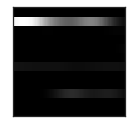

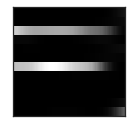

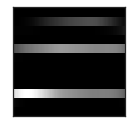

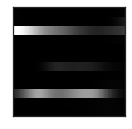

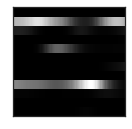

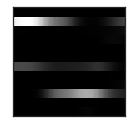

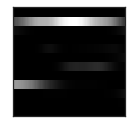

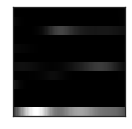

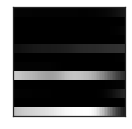

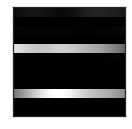

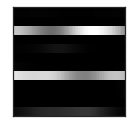

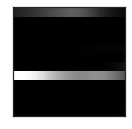

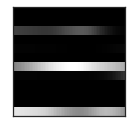

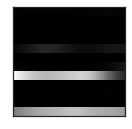

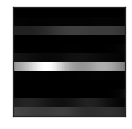

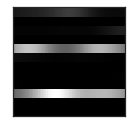

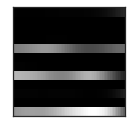

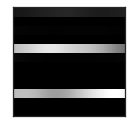

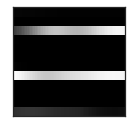

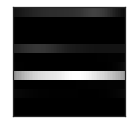

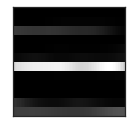

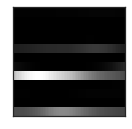

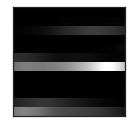

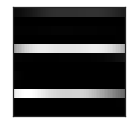

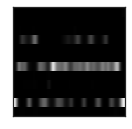

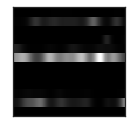

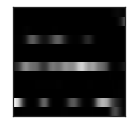

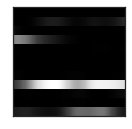

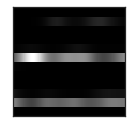

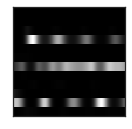

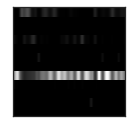

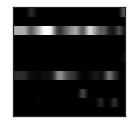

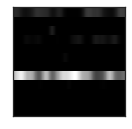

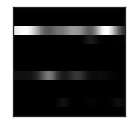

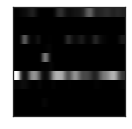

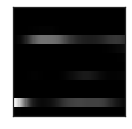

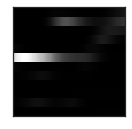

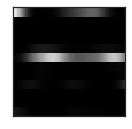

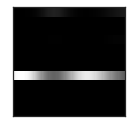

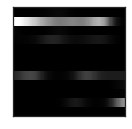

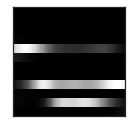

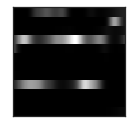

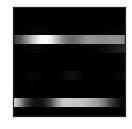

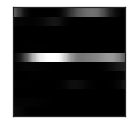

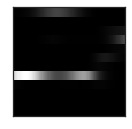

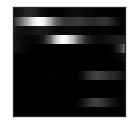

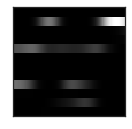

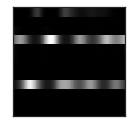

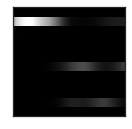

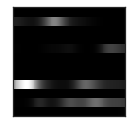

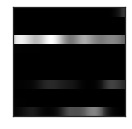

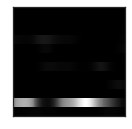

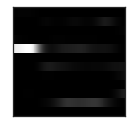

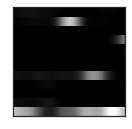

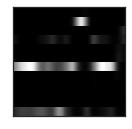

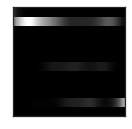

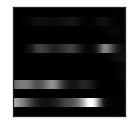

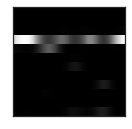

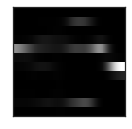

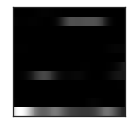

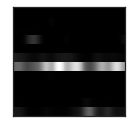

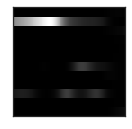

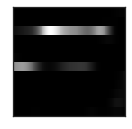

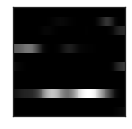

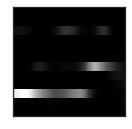

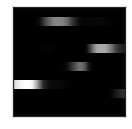

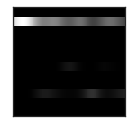

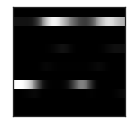

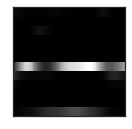

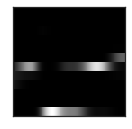

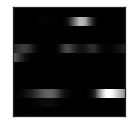

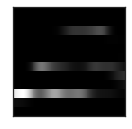

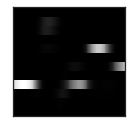

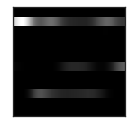

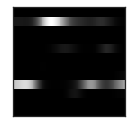

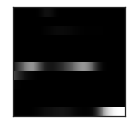

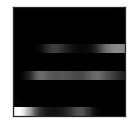

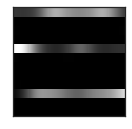

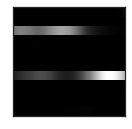

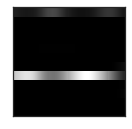

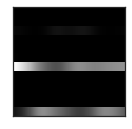

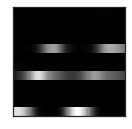

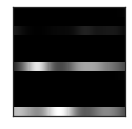

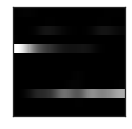

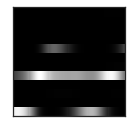

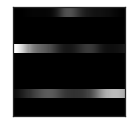

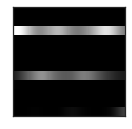

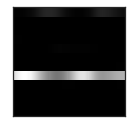

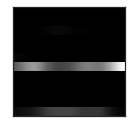

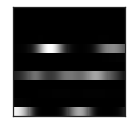

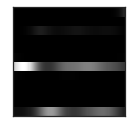

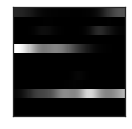

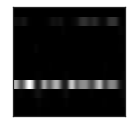

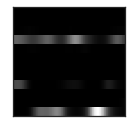

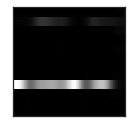

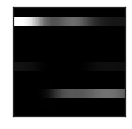

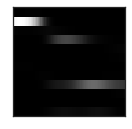

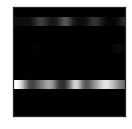

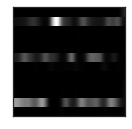

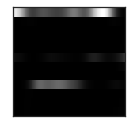

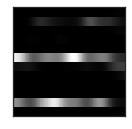

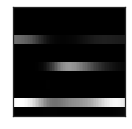

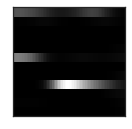

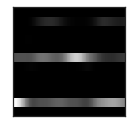

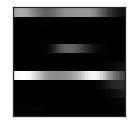

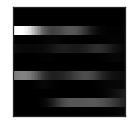

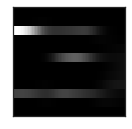

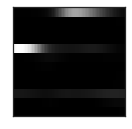

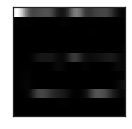

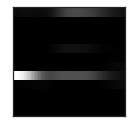

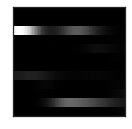

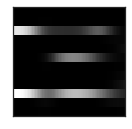

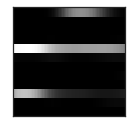

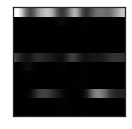

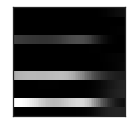

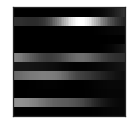

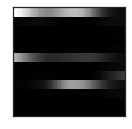

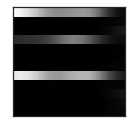

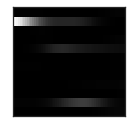

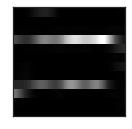

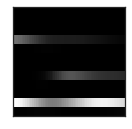

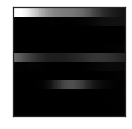

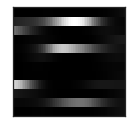

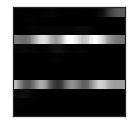

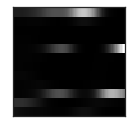

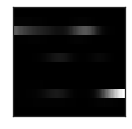

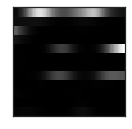

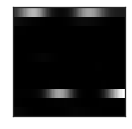

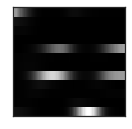

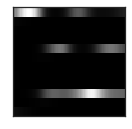

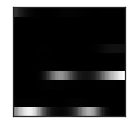

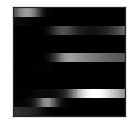

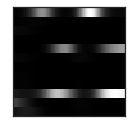

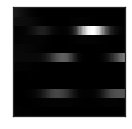

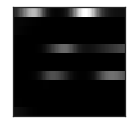

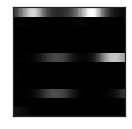

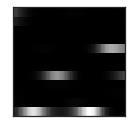

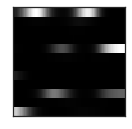

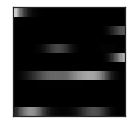

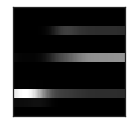

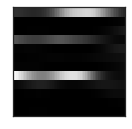

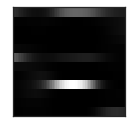

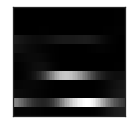

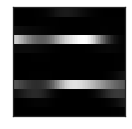

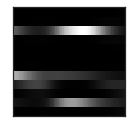

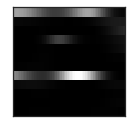

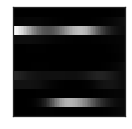

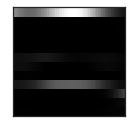

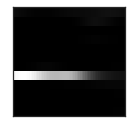

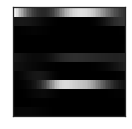

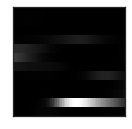

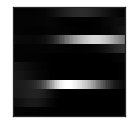

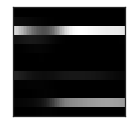

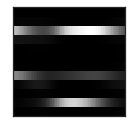

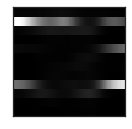

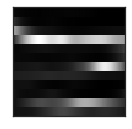

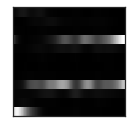

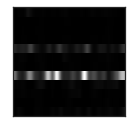

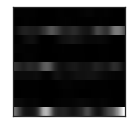

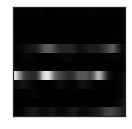

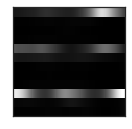

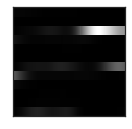

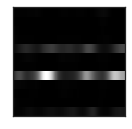

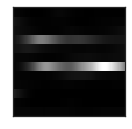

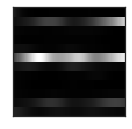

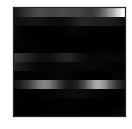

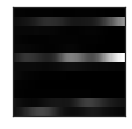

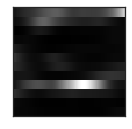

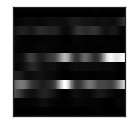

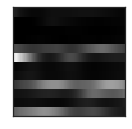

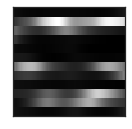

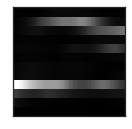

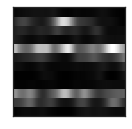

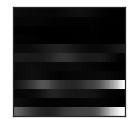

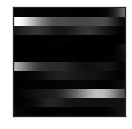

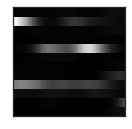

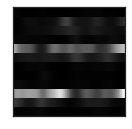

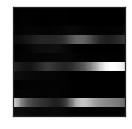

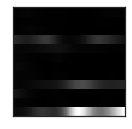

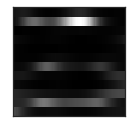

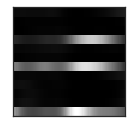

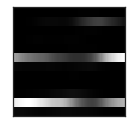

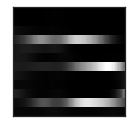

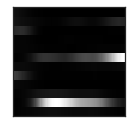

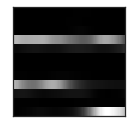

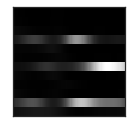

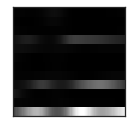

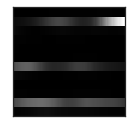

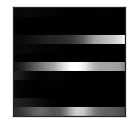

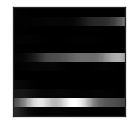

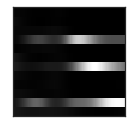

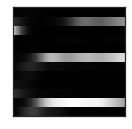

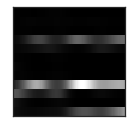

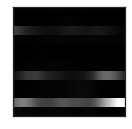

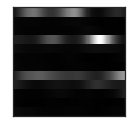

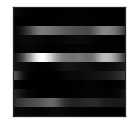

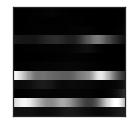

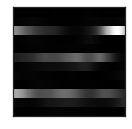

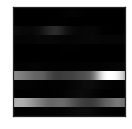

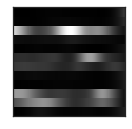

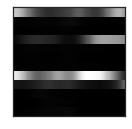

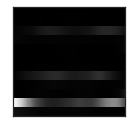

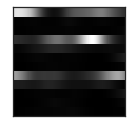

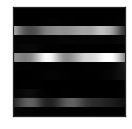

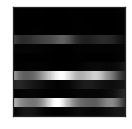

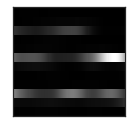

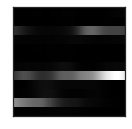

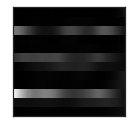

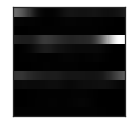

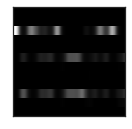

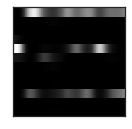

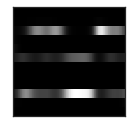

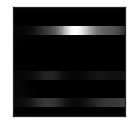

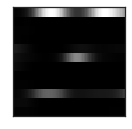

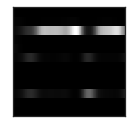

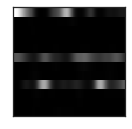

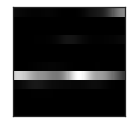

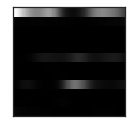

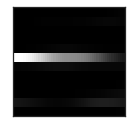

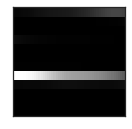

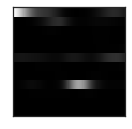

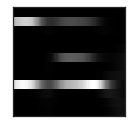

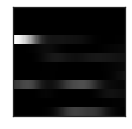

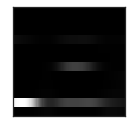

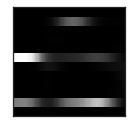

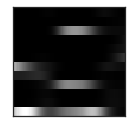

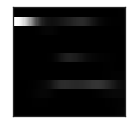

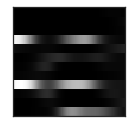

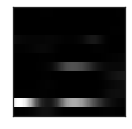

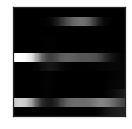

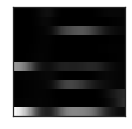

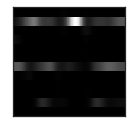

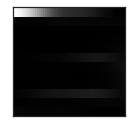

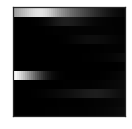

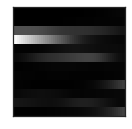

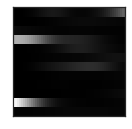

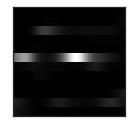

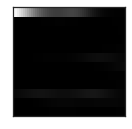

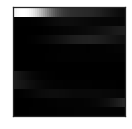

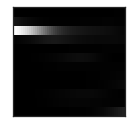

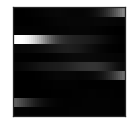

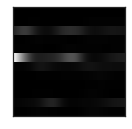

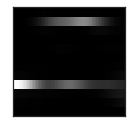

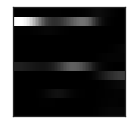

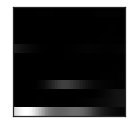

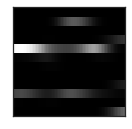

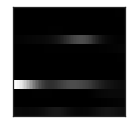

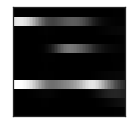

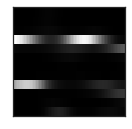

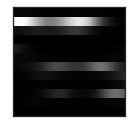

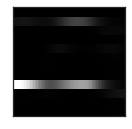

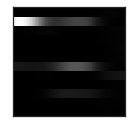

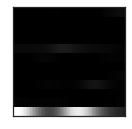

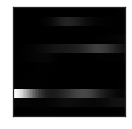

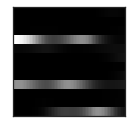

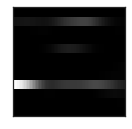

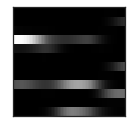

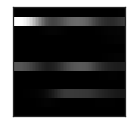

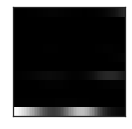

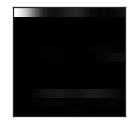

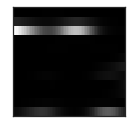

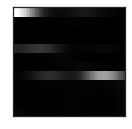

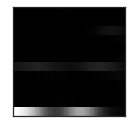

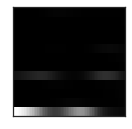

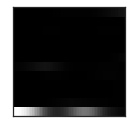

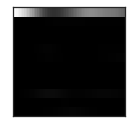

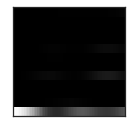

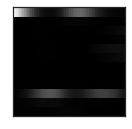

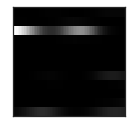

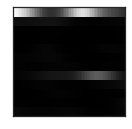

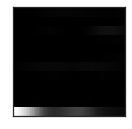

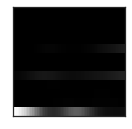

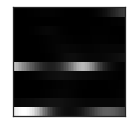

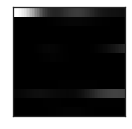

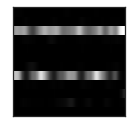

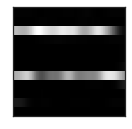

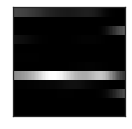

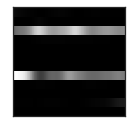

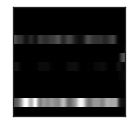

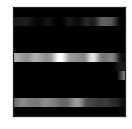

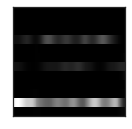

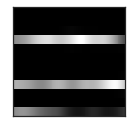

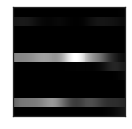

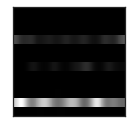

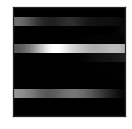

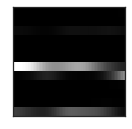

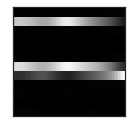

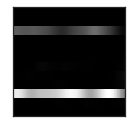

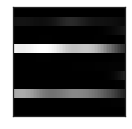

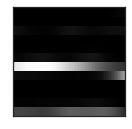

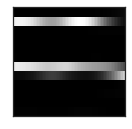

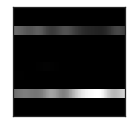

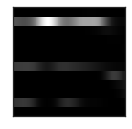

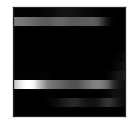

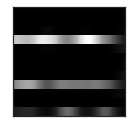

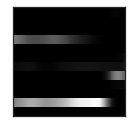

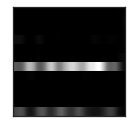

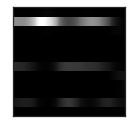

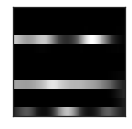

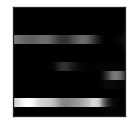

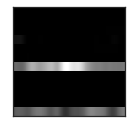

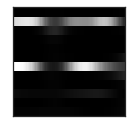

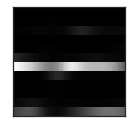

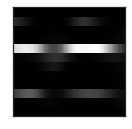

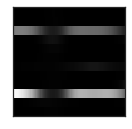

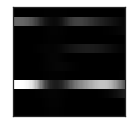

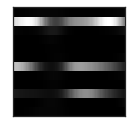

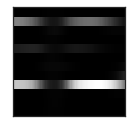

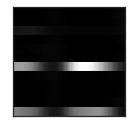

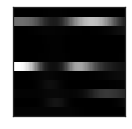

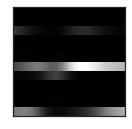

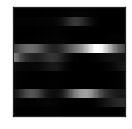

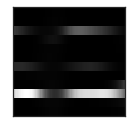

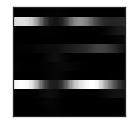

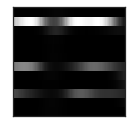

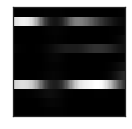

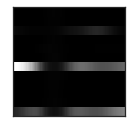

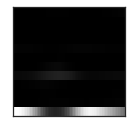

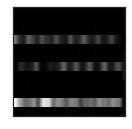

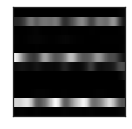

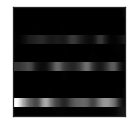

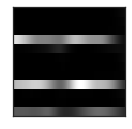

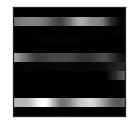

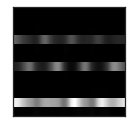

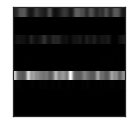

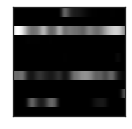

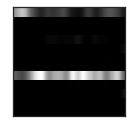

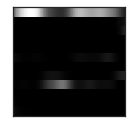

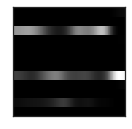

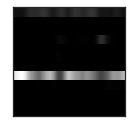

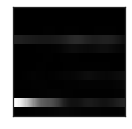

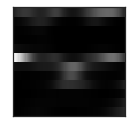

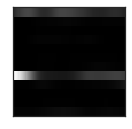

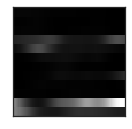

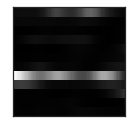

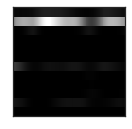

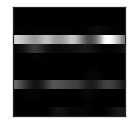

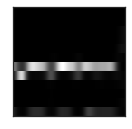

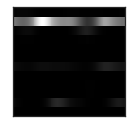

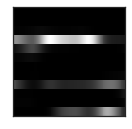

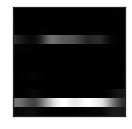

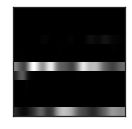

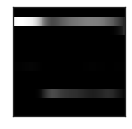

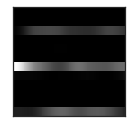

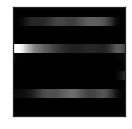

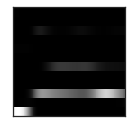

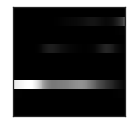

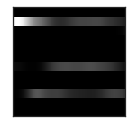

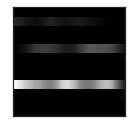

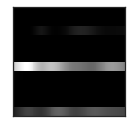

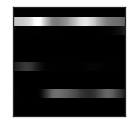

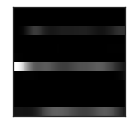

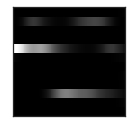

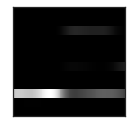

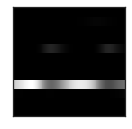

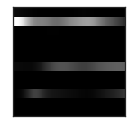

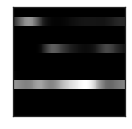

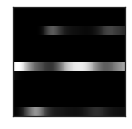

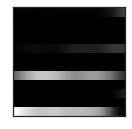

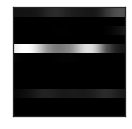

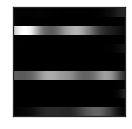

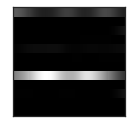

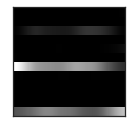

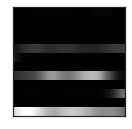

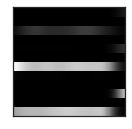

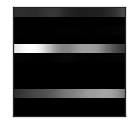

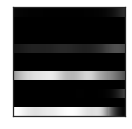

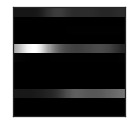

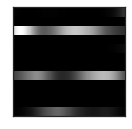

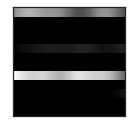

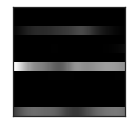

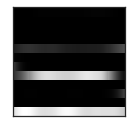

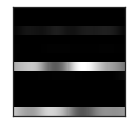

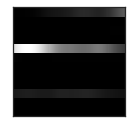

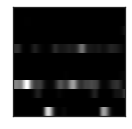

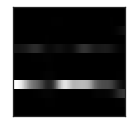

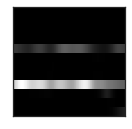

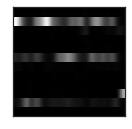

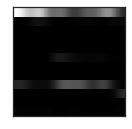

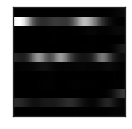

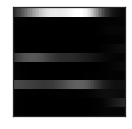

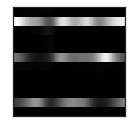

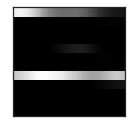

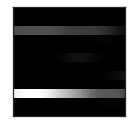

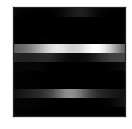

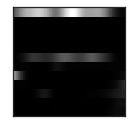

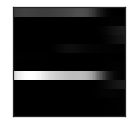

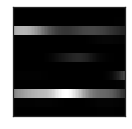

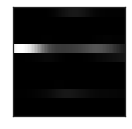

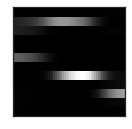

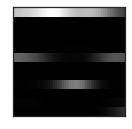

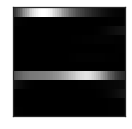

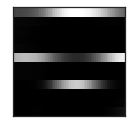

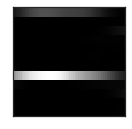

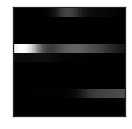

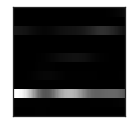

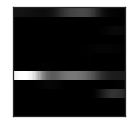

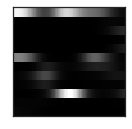

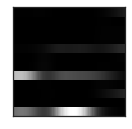

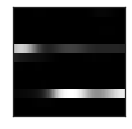

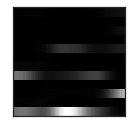

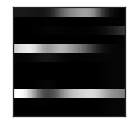

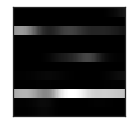

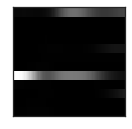

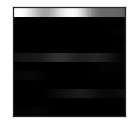

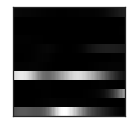

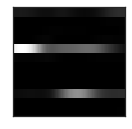

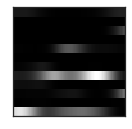

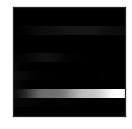

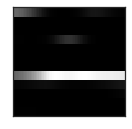

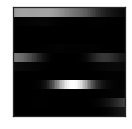

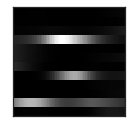

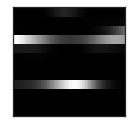

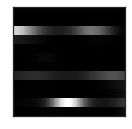

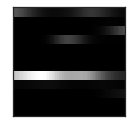

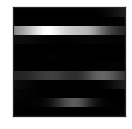

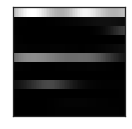

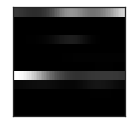

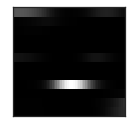

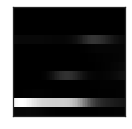

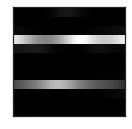

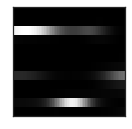

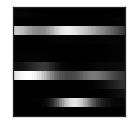

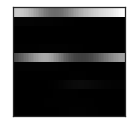

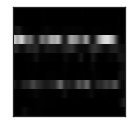

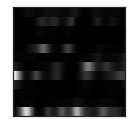

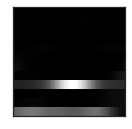

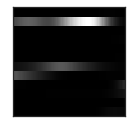

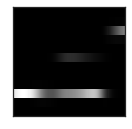

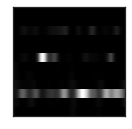

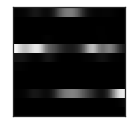

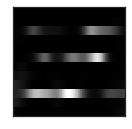

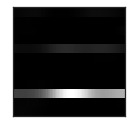

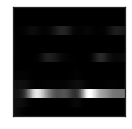

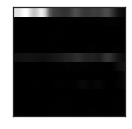

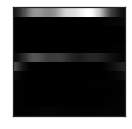

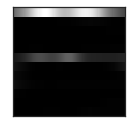

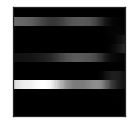

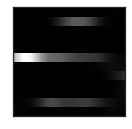

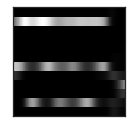

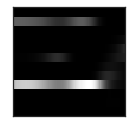

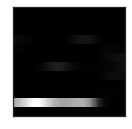

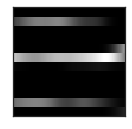

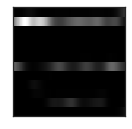

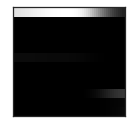

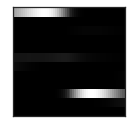

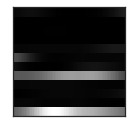

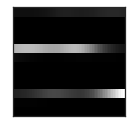

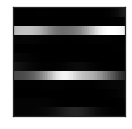

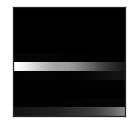

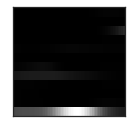

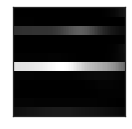

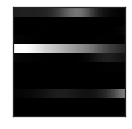

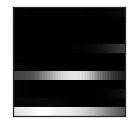

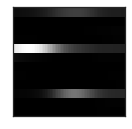

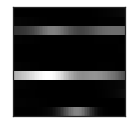

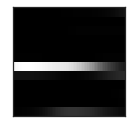

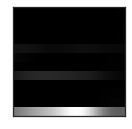

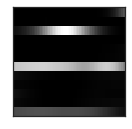

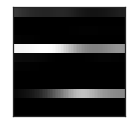

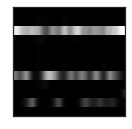

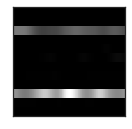

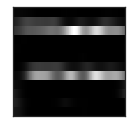

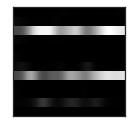

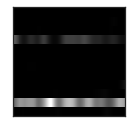

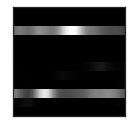

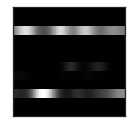

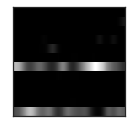

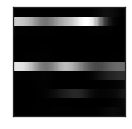

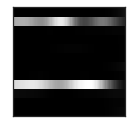

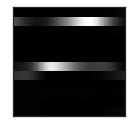

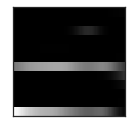

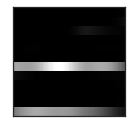

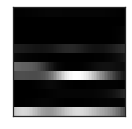

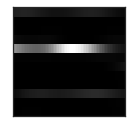

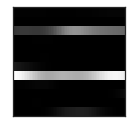

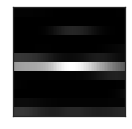

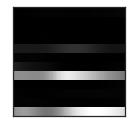

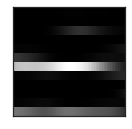

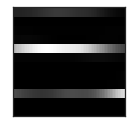

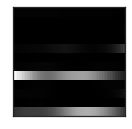

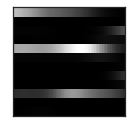

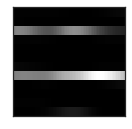

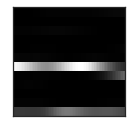

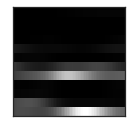

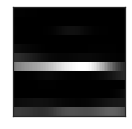

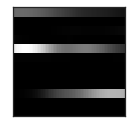

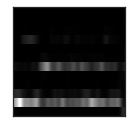

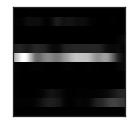

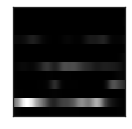

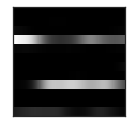

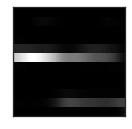

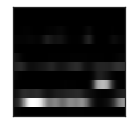

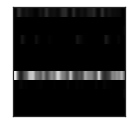

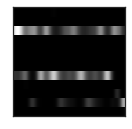

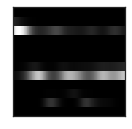

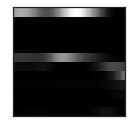

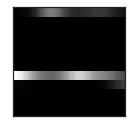

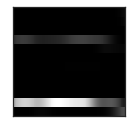

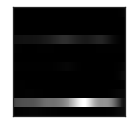

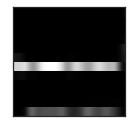

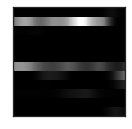

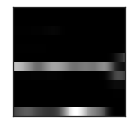

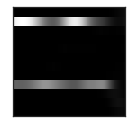

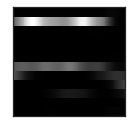

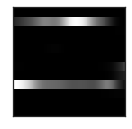

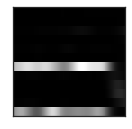

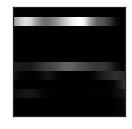

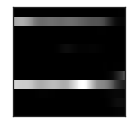

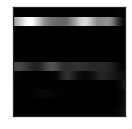

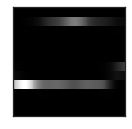

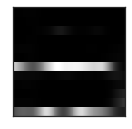

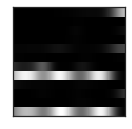

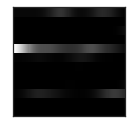

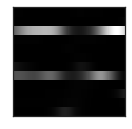

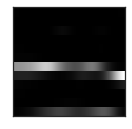

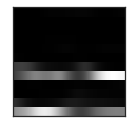

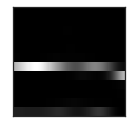

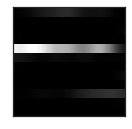

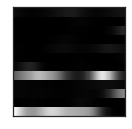

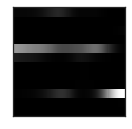

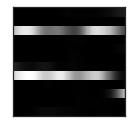

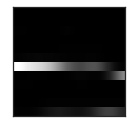

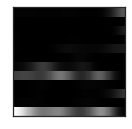

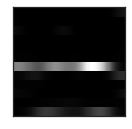

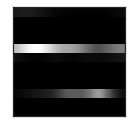

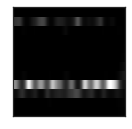

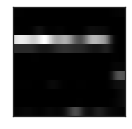

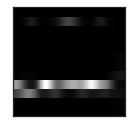

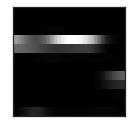

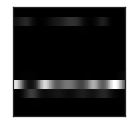

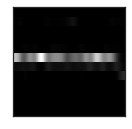

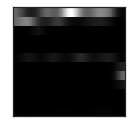

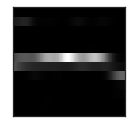

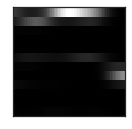

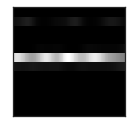

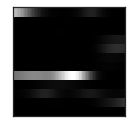

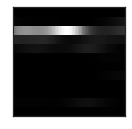

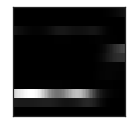

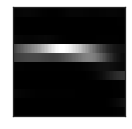

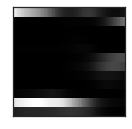

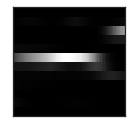

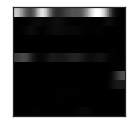

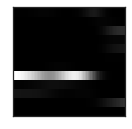

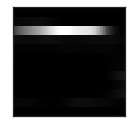

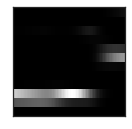

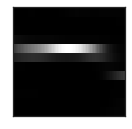

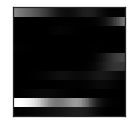

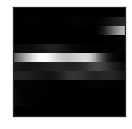

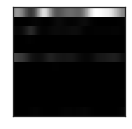

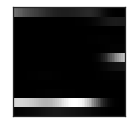

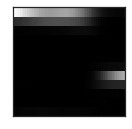

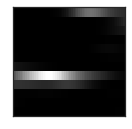

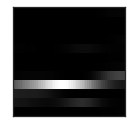

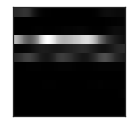

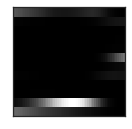

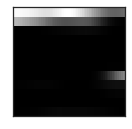

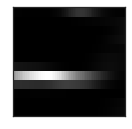

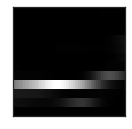

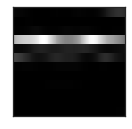

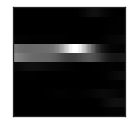

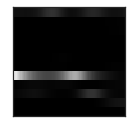

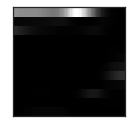

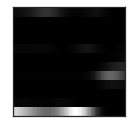

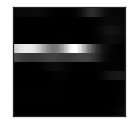

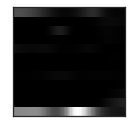

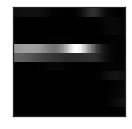

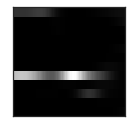

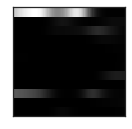

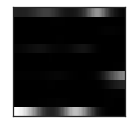

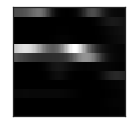

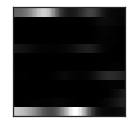

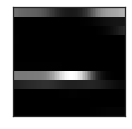

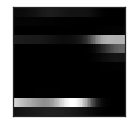

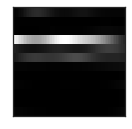

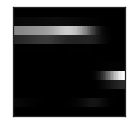

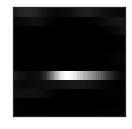

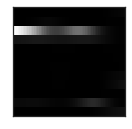

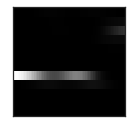

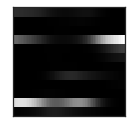

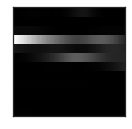

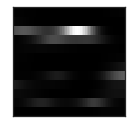

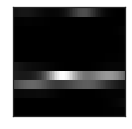

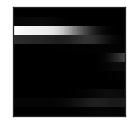

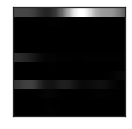

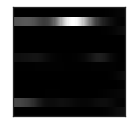

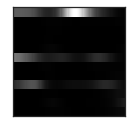

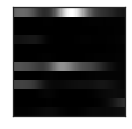

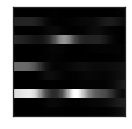

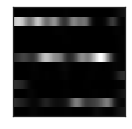

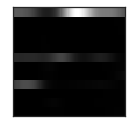

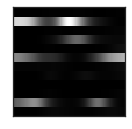

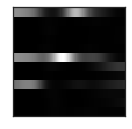

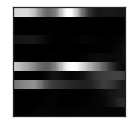

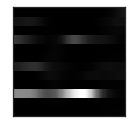

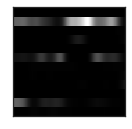

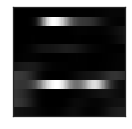

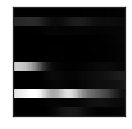

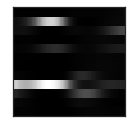

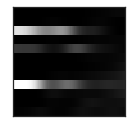

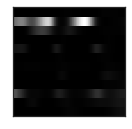

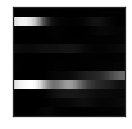

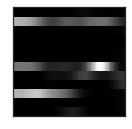

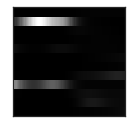

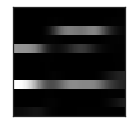

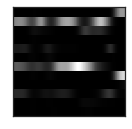

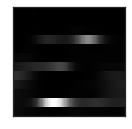

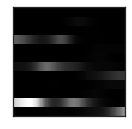

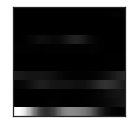

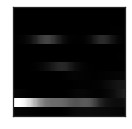

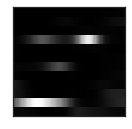

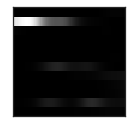

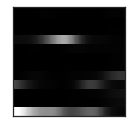

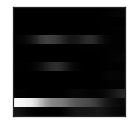

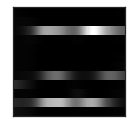

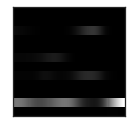

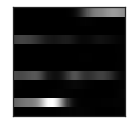

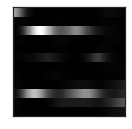

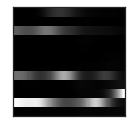

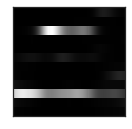

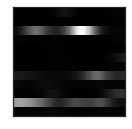

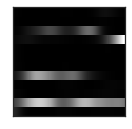

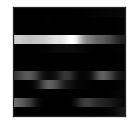

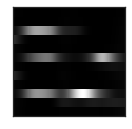

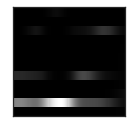

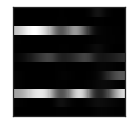

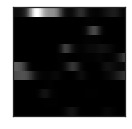

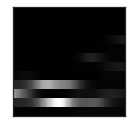

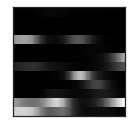

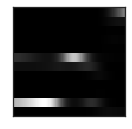

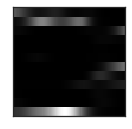

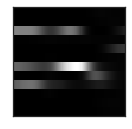

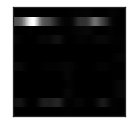

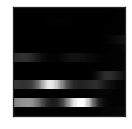

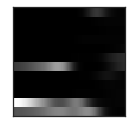

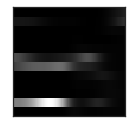

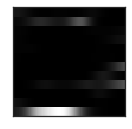

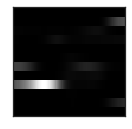

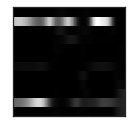

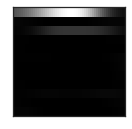

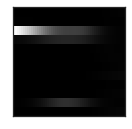

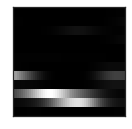

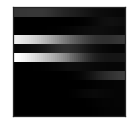

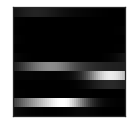

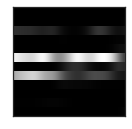

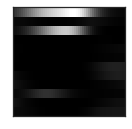

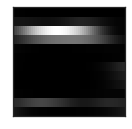

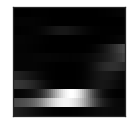

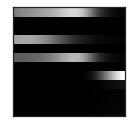

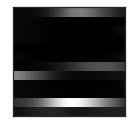

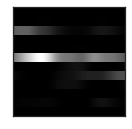

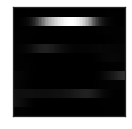

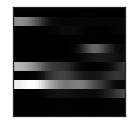

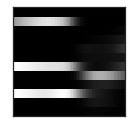

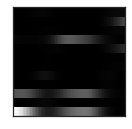

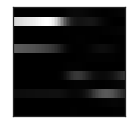

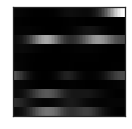

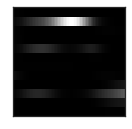

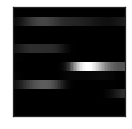

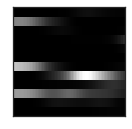

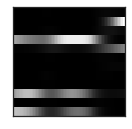

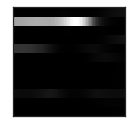

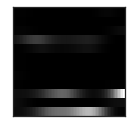

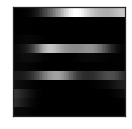

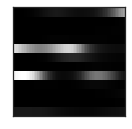

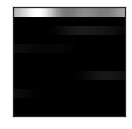

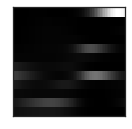

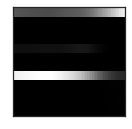

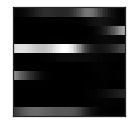

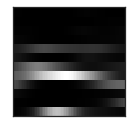

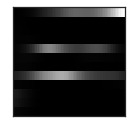

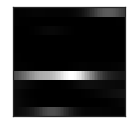

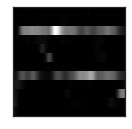

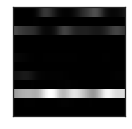

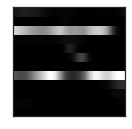

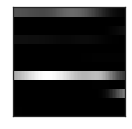

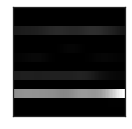

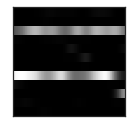

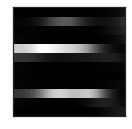

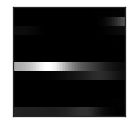

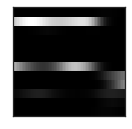

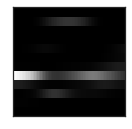

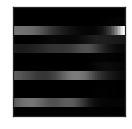

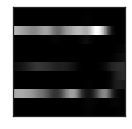

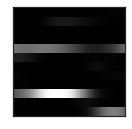

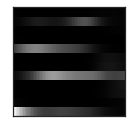

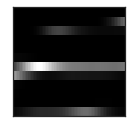

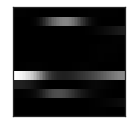

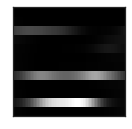

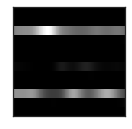

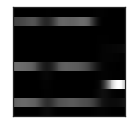

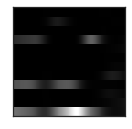

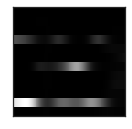

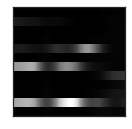

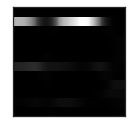

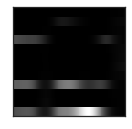

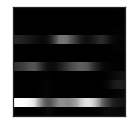

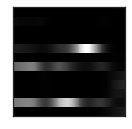

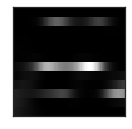

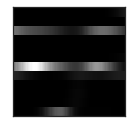

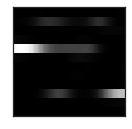

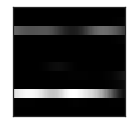

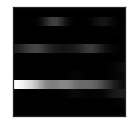

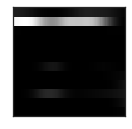

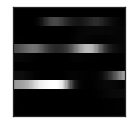

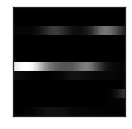

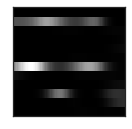

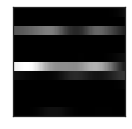

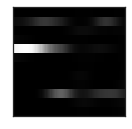

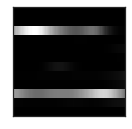

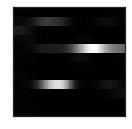

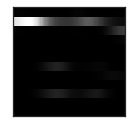

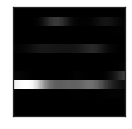

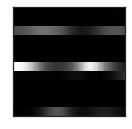

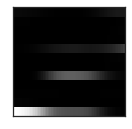

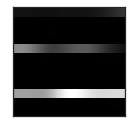

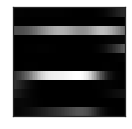

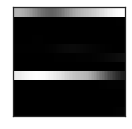

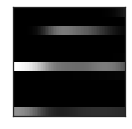

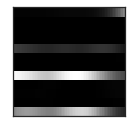

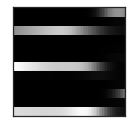

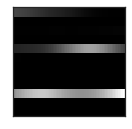

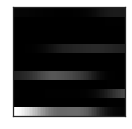

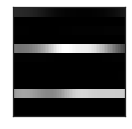

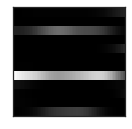

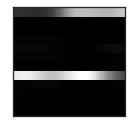

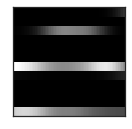

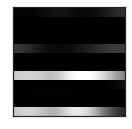

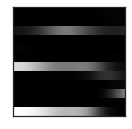

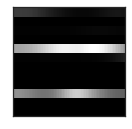

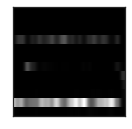

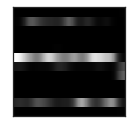

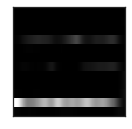

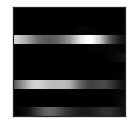

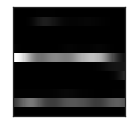

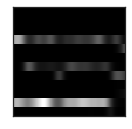

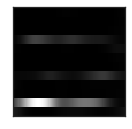

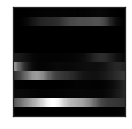

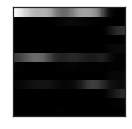

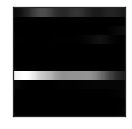

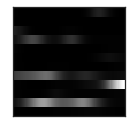

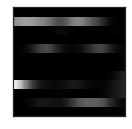

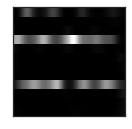

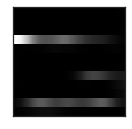

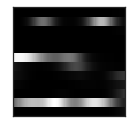

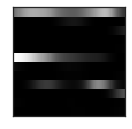

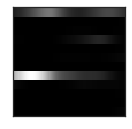

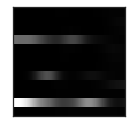

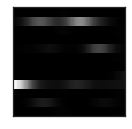

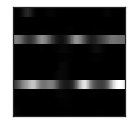

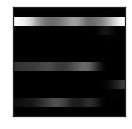

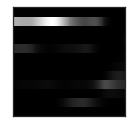

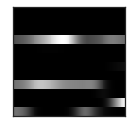

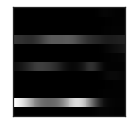

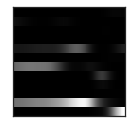

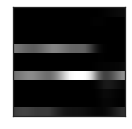

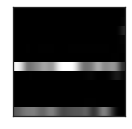

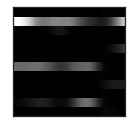

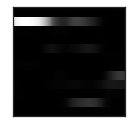

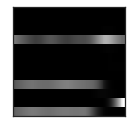

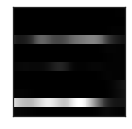

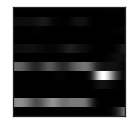

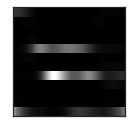

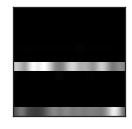

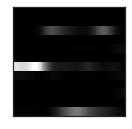

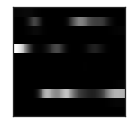

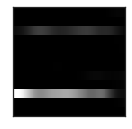

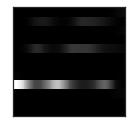

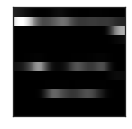

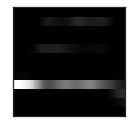

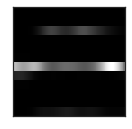

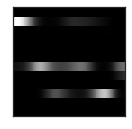

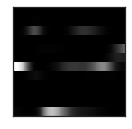

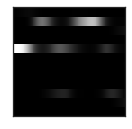

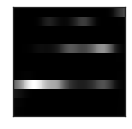

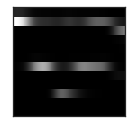

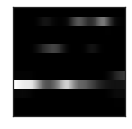

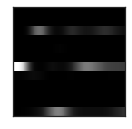

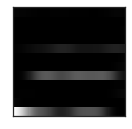

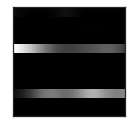

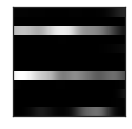

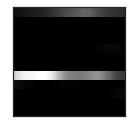

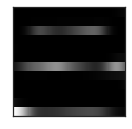

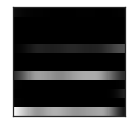

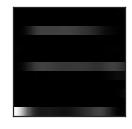

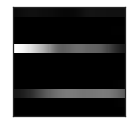

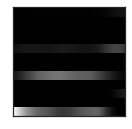

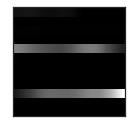

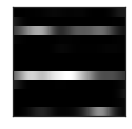

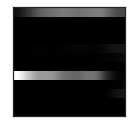

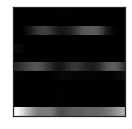

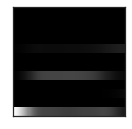

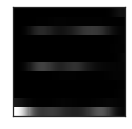

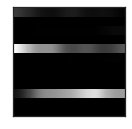

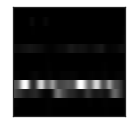

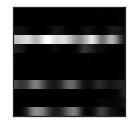

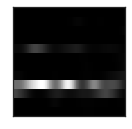

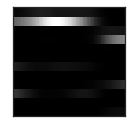

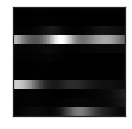

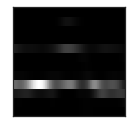

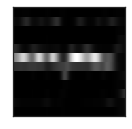

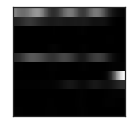

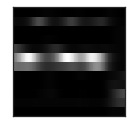

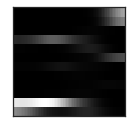

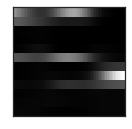

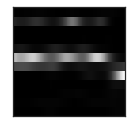

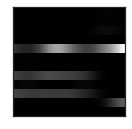

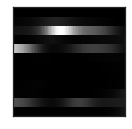

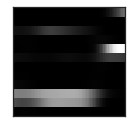

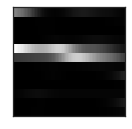

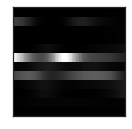

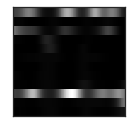

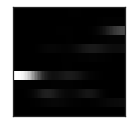

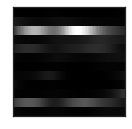

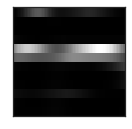

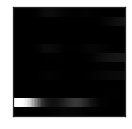

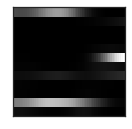

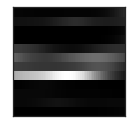

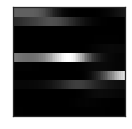

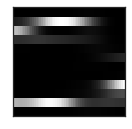

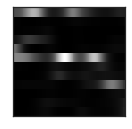

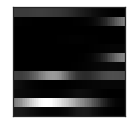

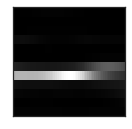

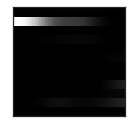

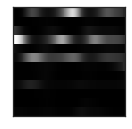

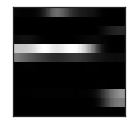

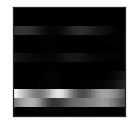

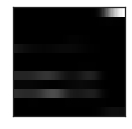

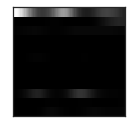

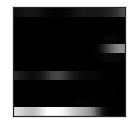

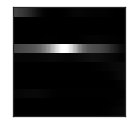

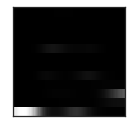

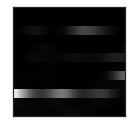

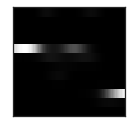

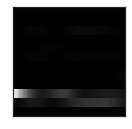

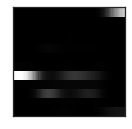

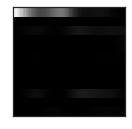

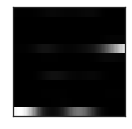

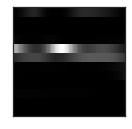

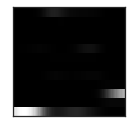

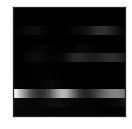

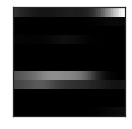

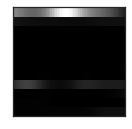

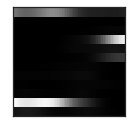

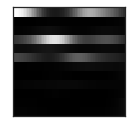

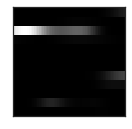

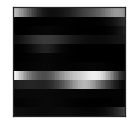

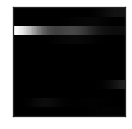

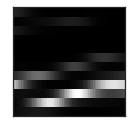

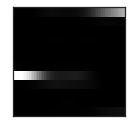

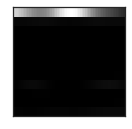

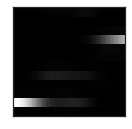

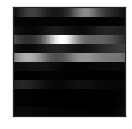

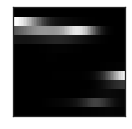

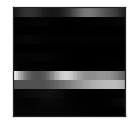

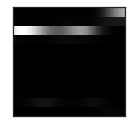

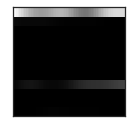

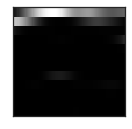

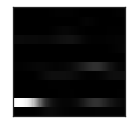

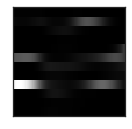

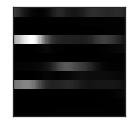

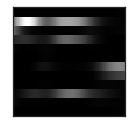

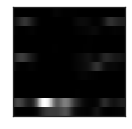

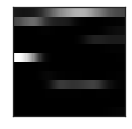

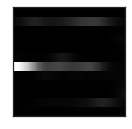

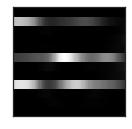

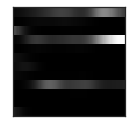

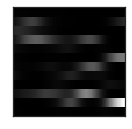

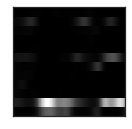

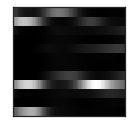

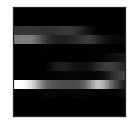

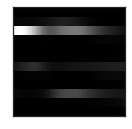

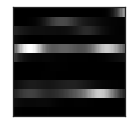

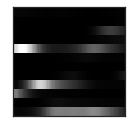

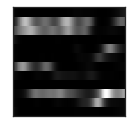

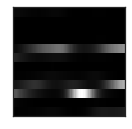

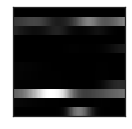

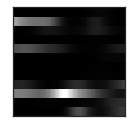

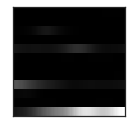

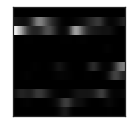

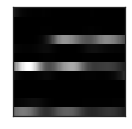

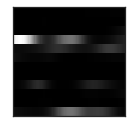

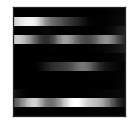

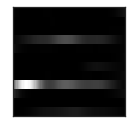

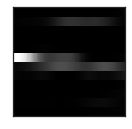

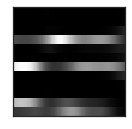

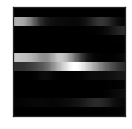

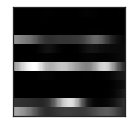

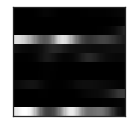

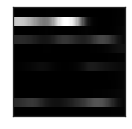

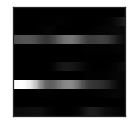

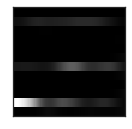

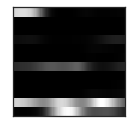

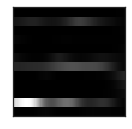

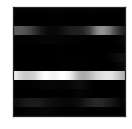

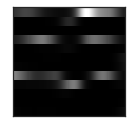

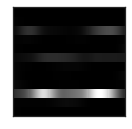

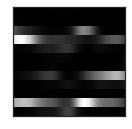

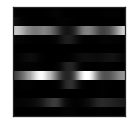

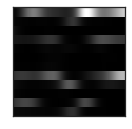

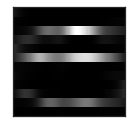

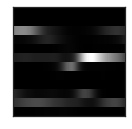

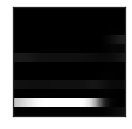

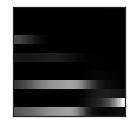

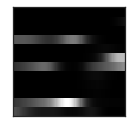

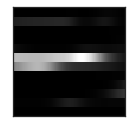

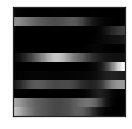

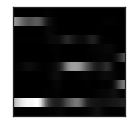

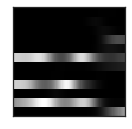

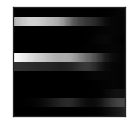

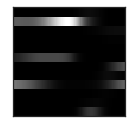

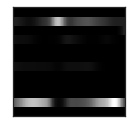

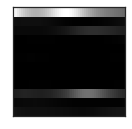

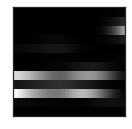

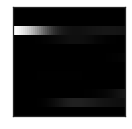

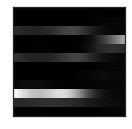

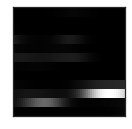

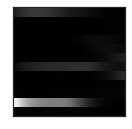

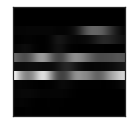

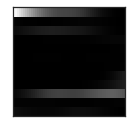

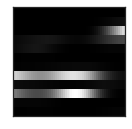

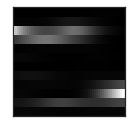

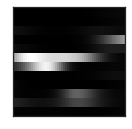

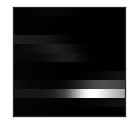

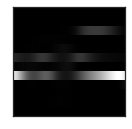

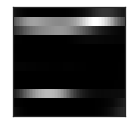

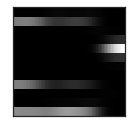

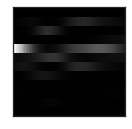

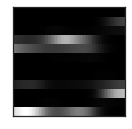

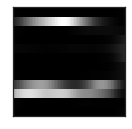

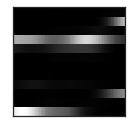

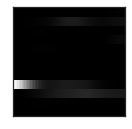

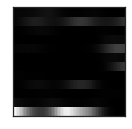

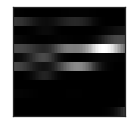

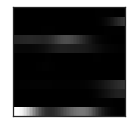

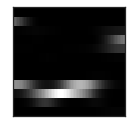

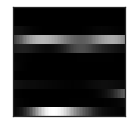

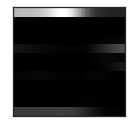

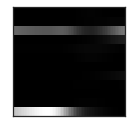

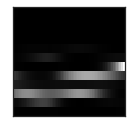

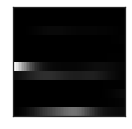

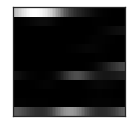

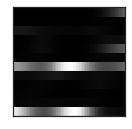

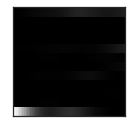

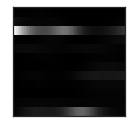

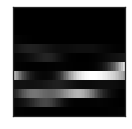

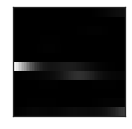

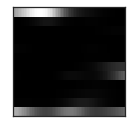

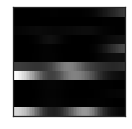

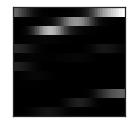

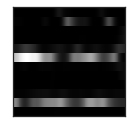

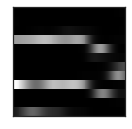

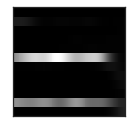

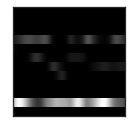

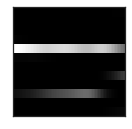

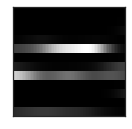

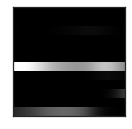

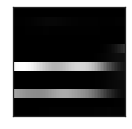

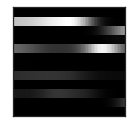

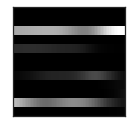

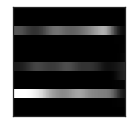

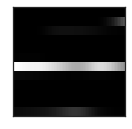

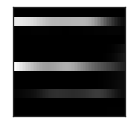

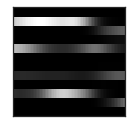

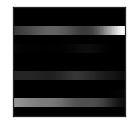

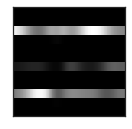

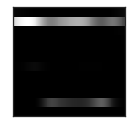

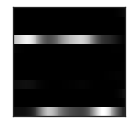

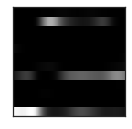

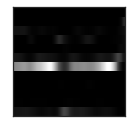

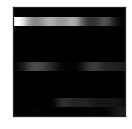

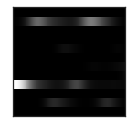

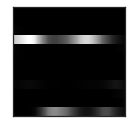

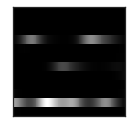

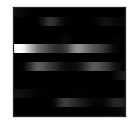

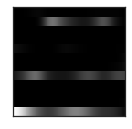

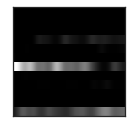

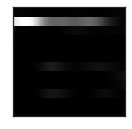

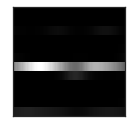

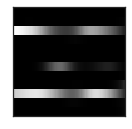

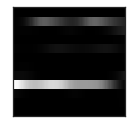

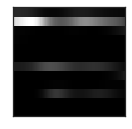

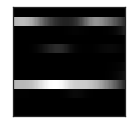

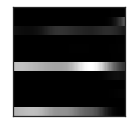

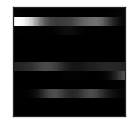

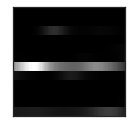

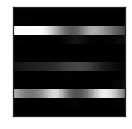

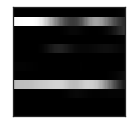

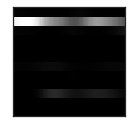

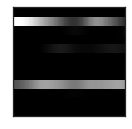

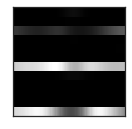

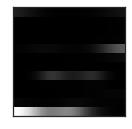

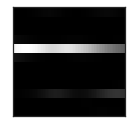

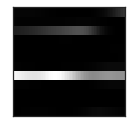

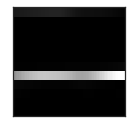

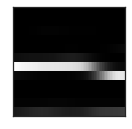

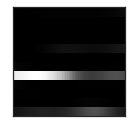

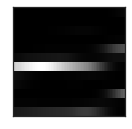

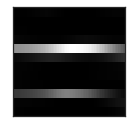

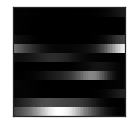

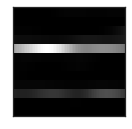

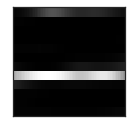

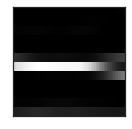

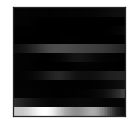

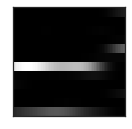

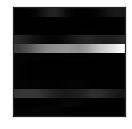

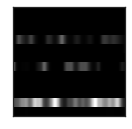

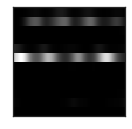

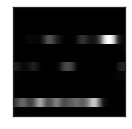

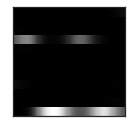

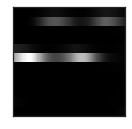

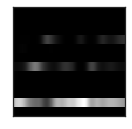

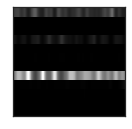

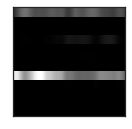

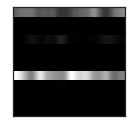

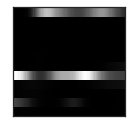

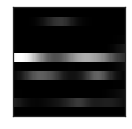

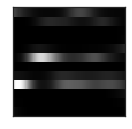

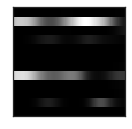

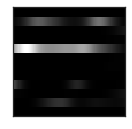

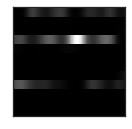

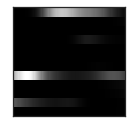

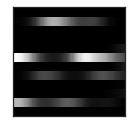

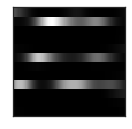

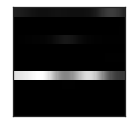

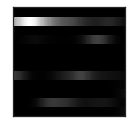

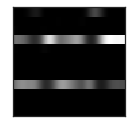

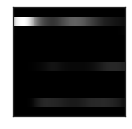

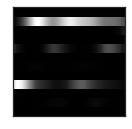

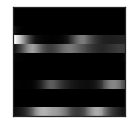

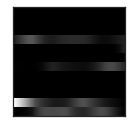

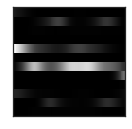

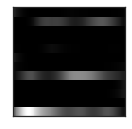

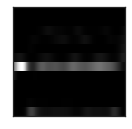

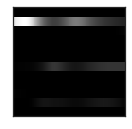

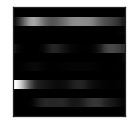

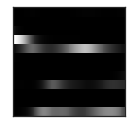

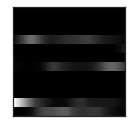

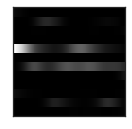

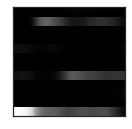

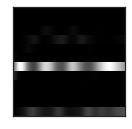

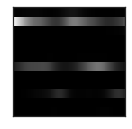

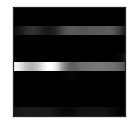

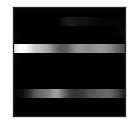

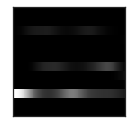

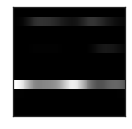

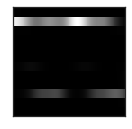

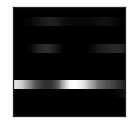

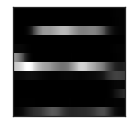

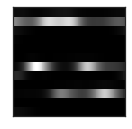

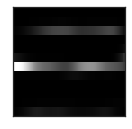

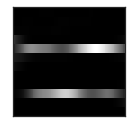

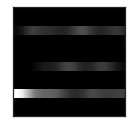

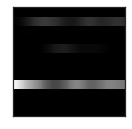

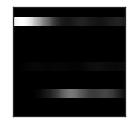

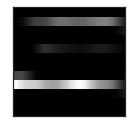

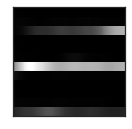

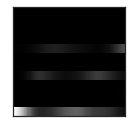

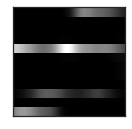

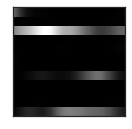

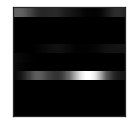

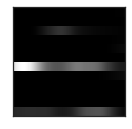

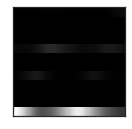

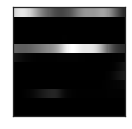

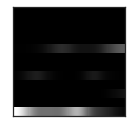

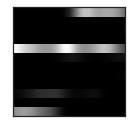

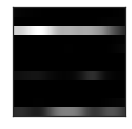

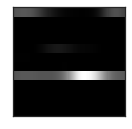

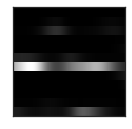

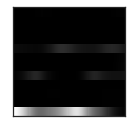

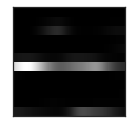

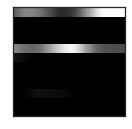

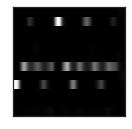

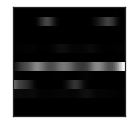

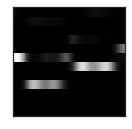

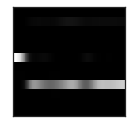

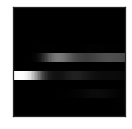

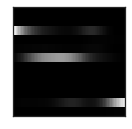

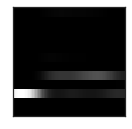

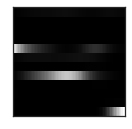

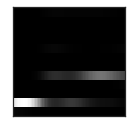

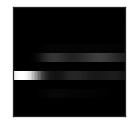

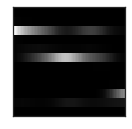

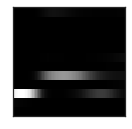

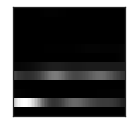

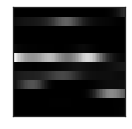

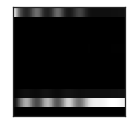

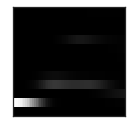

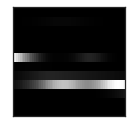

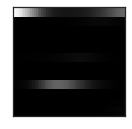

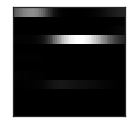

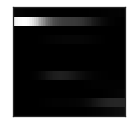

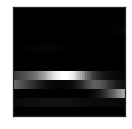

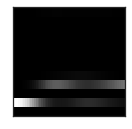

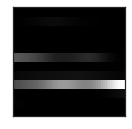

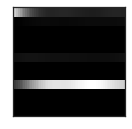

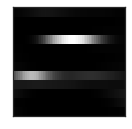

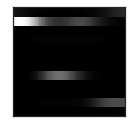

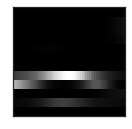

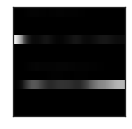

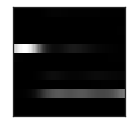

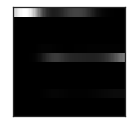

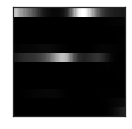

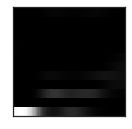

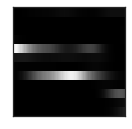

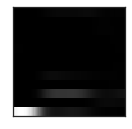

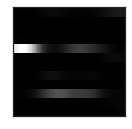

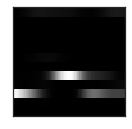

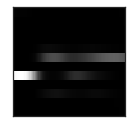

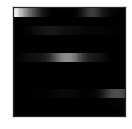

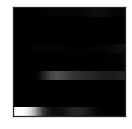

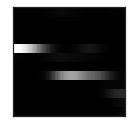

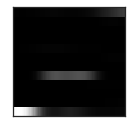

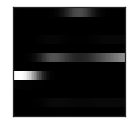

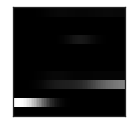

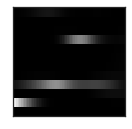

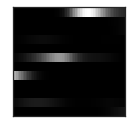

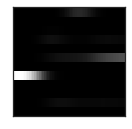

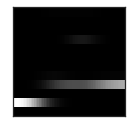

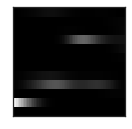

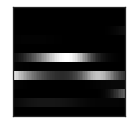

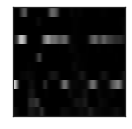

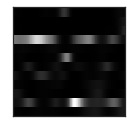

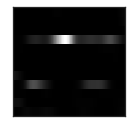

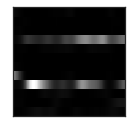

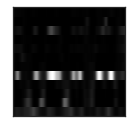

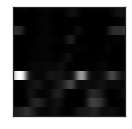

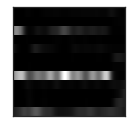

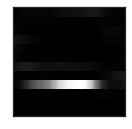

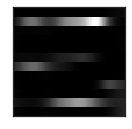

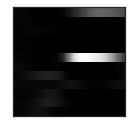

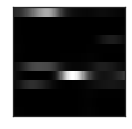

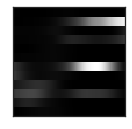

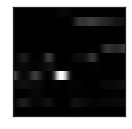

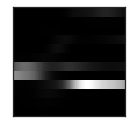

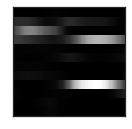

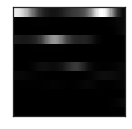

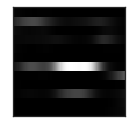

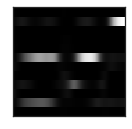

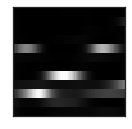

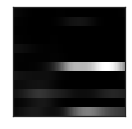

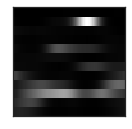

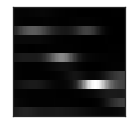

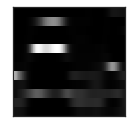

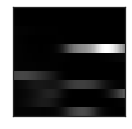

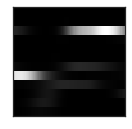

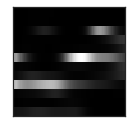

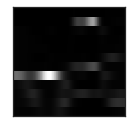

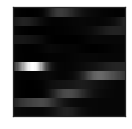

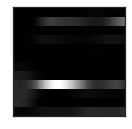

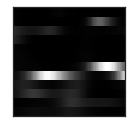

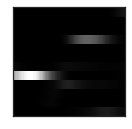

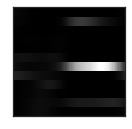

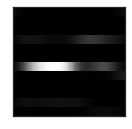

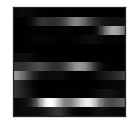

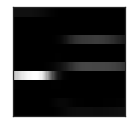

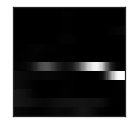

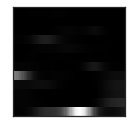

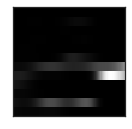

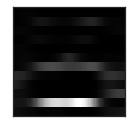

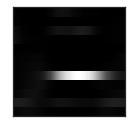

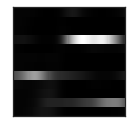

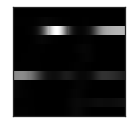

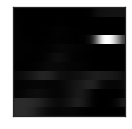

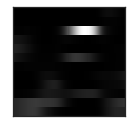

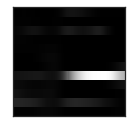

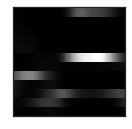

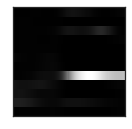

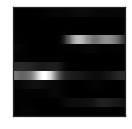

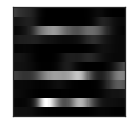

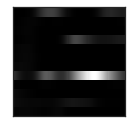

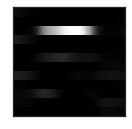

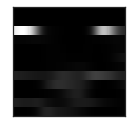

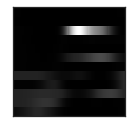

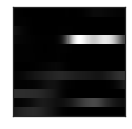

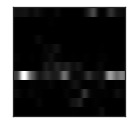

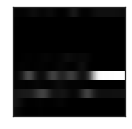

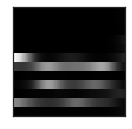

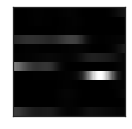

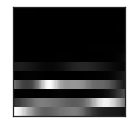

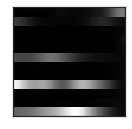

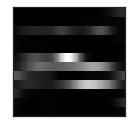

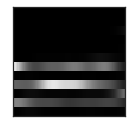

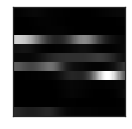

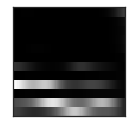

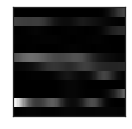

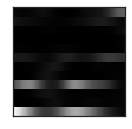

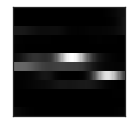

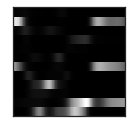

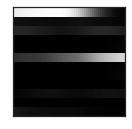

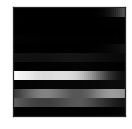

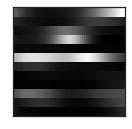

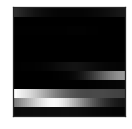

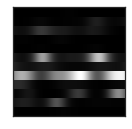

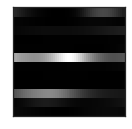

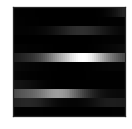

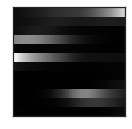

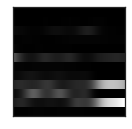

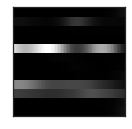

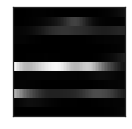

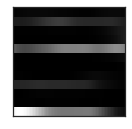

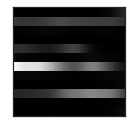

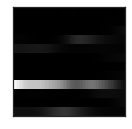

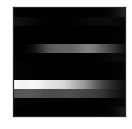

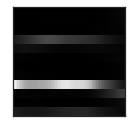

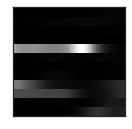

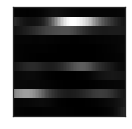

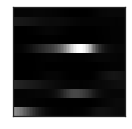

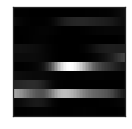

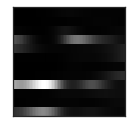

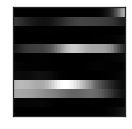

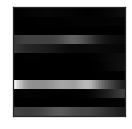

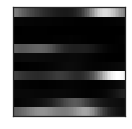

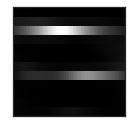

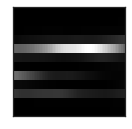

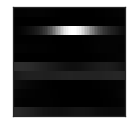

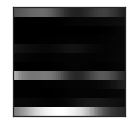

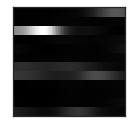

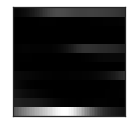

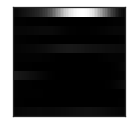

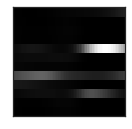

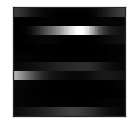

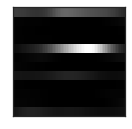

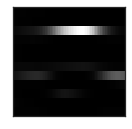

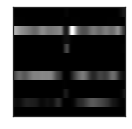

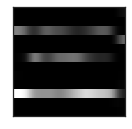

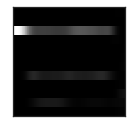

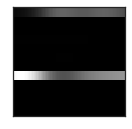

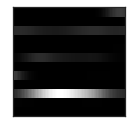

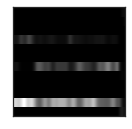

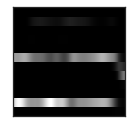

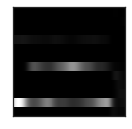

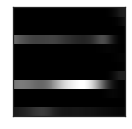

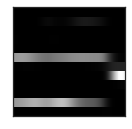

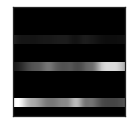

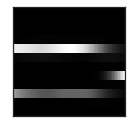

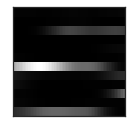

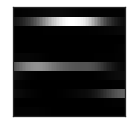

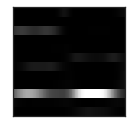

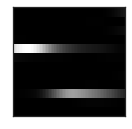

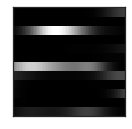

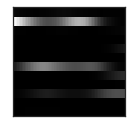

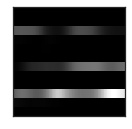

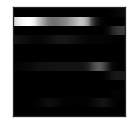

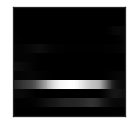

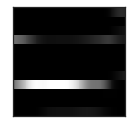

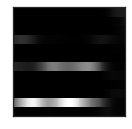

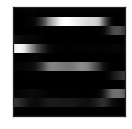

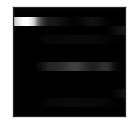

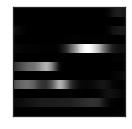

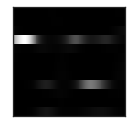

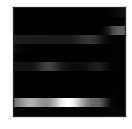

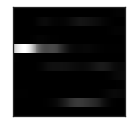

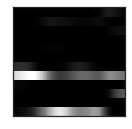

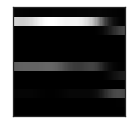

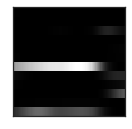

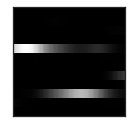

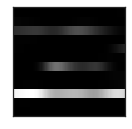

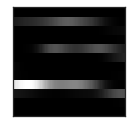

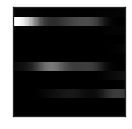

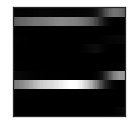

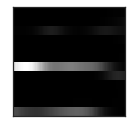

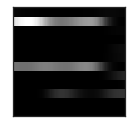

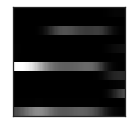

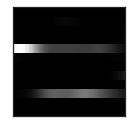

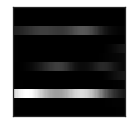

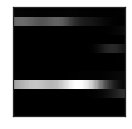

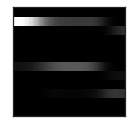

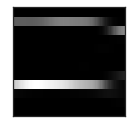

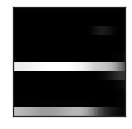

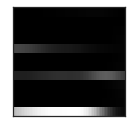

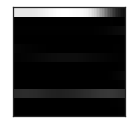

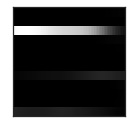

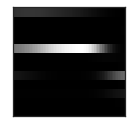

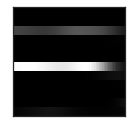

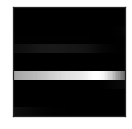

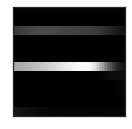

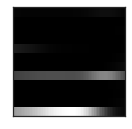

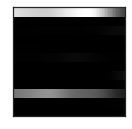

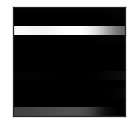

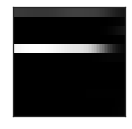

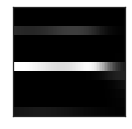

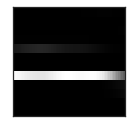

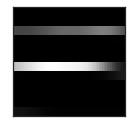

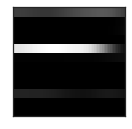

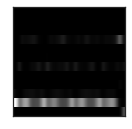

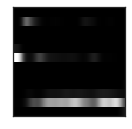

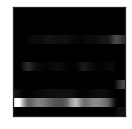

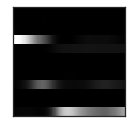

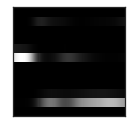

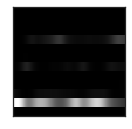

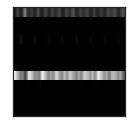

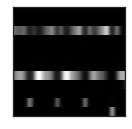

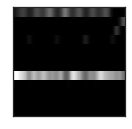

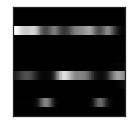

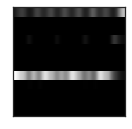

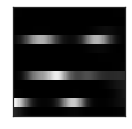

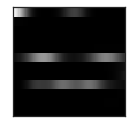

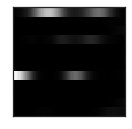

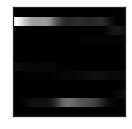

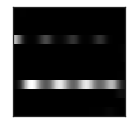

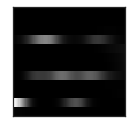

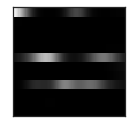

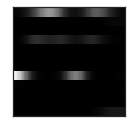

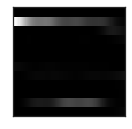

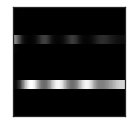

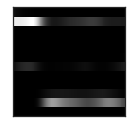

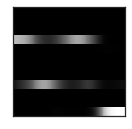

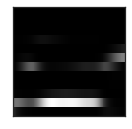

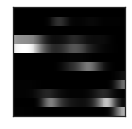

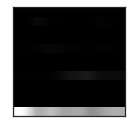

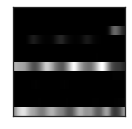

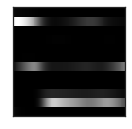

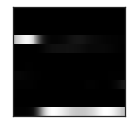

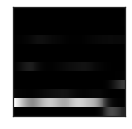

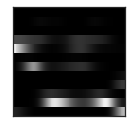

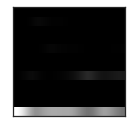

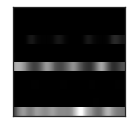

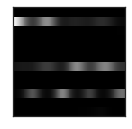

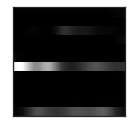

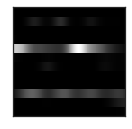

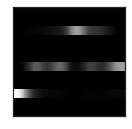

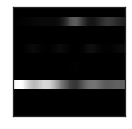

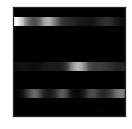

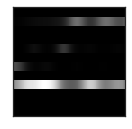

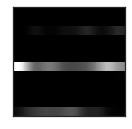

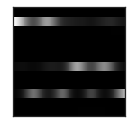

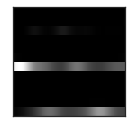

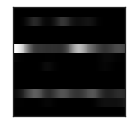

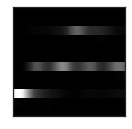

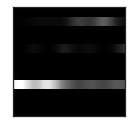

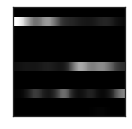

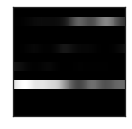

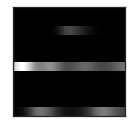

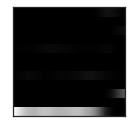

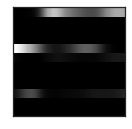

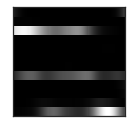

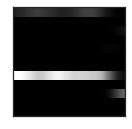

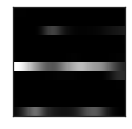

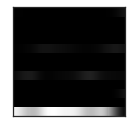

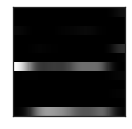

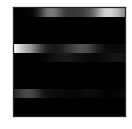

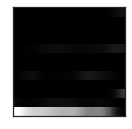

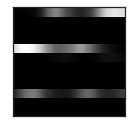

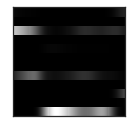

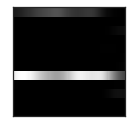

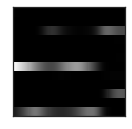

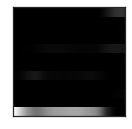

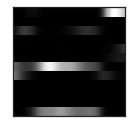

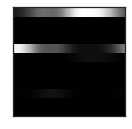

In [131]:
for file in audio_files:
    chords_data = chords_comp_clean[chords_comp_clean.track_name == file[:-12]]
    
    for i in range(len(chords_data.time)):
        name = list(chords_data.id)[i]
        data, sr = librosa.load(path_audio + file, offset=list(chords_data.time)[i], duration=list(chords_data.duration)[i])

        # create chromagram
        chromagram = librosa.feature.chroma_cens(data, sr=sr)
        chromagram_mag = librosa.magphase(chromagram)[0]**4

        # save image
        fig = plt.figure(figsize=(2, 2))
        librosa.display.specshow(chromagram_mag, sr=sr, cmap='gray')
        fig.savefig(path_images + name)
        plt.close()

In [29]:
chords_data.id.values

array(['00_Funk3-98-A_comp_0', '00_Funk3-98-A_comp_1',
       '00_Funk3-98-A_comp_3', '00_Funk3-98-A_comp_4',
       '00_Funk3-98-A_comp_5', '00_Funk3-98-A_comp_6',
       '00_Funk3-98-A_comp_7', '00_Funk3-98-A_comp_8',
       '00_Funk3-98-A_comp_9', '00_Funk3-98-A_comp_10',
       '00_Funk3-98-A_comp_11', '00_Funk3-98-A_comp_12',
       '00_Funk3-98-A_comp_13'], dtype=object)

In [122]:
chords_comp_clean.head()

,id,track_name,time,duration,chord_instructed,chord_played,to_keep
0,00_BN1-129-Eb_comp_1,00_BN1-129-Eb_comp,7.441860,3.720930,G#:maj,G#:maj6(*5)/1,True
1,00_BN1-129-Eb_comp_2,00_BN1-129-Eb_comp,11.162791,3.720930,D#:maj,D#:maj7/1,True
2,00_BN1-129-Eb_comp_3,00_BN1-129-Eb_comp,14.883721,1.860465,A#:maj,A#:maj/1,True
3,00_BN1-129-Eb_comp_4,00_BN1-129-Eb_comp,16.744186,1.860465,G#:maj,"G#:maj6(2,b5,*5)/1",True
4,00_BN1-129-Eb_comp_5,00_BN1-129-Eb_comp,18.604651,3.719749,D#:maj,D#:maj7/1,True


In [127]:
chords_data.time

5     0.000000
6     6.530612
7     9.795918
8    14.693878
9    16.326531
Name: time, dtype: float64

In [129]:
list(chords_data.id)[2]

'00_BN2-131-B_comp_2'